# Milestone 3 Assignment - Capstone Project

## Author - Connor Higgins

## Problem and Key Insight

### Problem & Background

<p>Created by EPA's <i>ENERGY STAR</i>, a program whose goal is to help businesses with energy efficiency, the Energy Star score is a rating (1-100) that compares the energy comsumption of similar buildings across the U.S. By earning a score of 75 or above for 12 consecutive months, buildings can earn an Energy Star certification.</p>

<p> In a hypothetical scenario, suppose a Seattle developer is interested in earning Energy Star certifications for current and future properties. However, before beginning the year-long energy recording and certification process for each building, they are looking for a method to quickly determine whether a property is a good candidate for certification. Furthermore, the developer wants to know which building attributes are most indicative of a good Energy Star score, as well as whether the importance of a particular attribute changes with respect to city, as they also have properties in Chicago.</p>
    
<p>For this project, four Energy Star benchmarking datasets were obtained: 3 Seattle-based datasets (2015, 2016, and 2017) and one Chicago-based (2014-2016) dataset. Along with Energy Star scores, the datasets are comprised of various building attributes concerning energy and property use.</p>
    
<p>This notebook represents the final third of the project. While the 2nd part (<a href="https://github.com/connor1higgins/Projects/blob/master/UWDataScience/PartIII/CH-M02-Capstone-Checkin.ipynb">Source</a>) largely focused on testing various models for both multi-classification (correctly identifying a building's Energy Star score quintile) and regression (correctly predicting a building's Energy Star score) across Seattle 2015, 2016, 2017, and Chicago datasets, this notebook instead focuses on creating a strong binary classification model, one that can accurately distinguish buildings with top Energy Star scores (>=90) from those with lower scores (<90) for both an aggregated Seattle (2015-2017) and Chicago (2014-2016) dataset.</p>
    <img width='500px' src="https://i.ytimg.com/vi/u3wbcxhHdHk/maxresdefault.jpg">

### Conclusions
After additional data preparation and feature engineering, an Extra Trees classifier was used for feature selection, providing  'selected feature' versions of both Seattle and Chicago datasets (Figure 9, 10). To determine the effect of reducing the number of features, these versions were used for modeling alongside their original 'all feature' counterparts.

Based on their performance during the 2nd part of this project, K-Nearest Neighbors (KNN), Decision Tree (DT), and Support Vector (SV) classifiers were fitted to the training entries of each dataset and evaluated for their performance on several key metrics, such as accuracy and precision, when identifying test entries in the form of a binary classification problem, with Energy Star scores less than 90 being Class 0 and scores greater or equal to 90 being Class 1. 

For the Seattle dataset, a KNN classifier using selected features was shown to be the most effective at identifying a building's Energy Star class, achieving 86.07% accuracy on the test data (Figure 12). In contrast, for the Chicago dataset, a SV classifier using all features was shown to be the most effective, achieving 92.16% accuracy (Figure 26).

For both models, Site Energy Use Intensity Weather Normalized (SiteEUIWN) and Source Energy Use Intensity Weather Normalized (SourceEUIWN) were key features, as demonstrated during data exploration (Figure 4, 8) and during evaluation (Figure 16, 18, 20). SiteEUIWN is calculated as a building's overall energy use with respect to utility usage divided by its gross floor area, factoring in variable weather conditions. SourceEUIWN is similarly calculated, yet is done so with respect to the annual energy used to operate the property, including any energy loss during generation or transmission. Additionally, Greenhouse Gas Emissions Intensity (GHGEmissionsIntensity), calculated as the total greenhouse gas emissions divided by the property's gross floor area, was shown to be an important component of the Chicago model (Figure 5, 22), but not the Seattle model. This may suggest that location is a factor influencing Energy Star score calculation.

### Next Steps
In order to improve upon both Chicago and Seattle binary classification models, the first step would be to fine-tune the hyperparameters further for both the KNN and SV pipelines using an updated search grid. This would reduce the speed of training beyond the scope of this notebook, yet it would ensure that no highly performant hyperparameter combinations were overlooked. 

The next step would be to look at a different method of feature selection. While this project utilized the Extra Trees classifier, scikit-learn's SelectKBest is another good option, as is mlxtend's SequentialFeatureSelector. Running comparisons of the selected feature models would also provide more information as to which features are most predicitive of Energy Star class. 

Finally, if the objective is to maximize classification performance, an artifical neural network (ANN) could be used in place of a KNN or SV classifier. However, this would not only effectively make the model a 'black box' but also drastically increase training and adjustment time. Other potential models include ensembles, such as a random forest (RF) classifier. 

## Data Exploration and Preparation

### Sources
The Seattle dataset is the aggregate of three separate datasets, distinguished by the year recordings were taken (2015, 2016, and 2017). The 2015 and 2016 Seattle datasets were obtained from Kaggle ([Source](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking)) and were provided as part of a mandate the Seattle City Council passed in 2016, making the data for all buildings 20,000 square feet and larger available annually. Reportedly, both datasets represent nearly a third of Seattle's annual emissions. The 2017 dataset, released November 2018, was obtained directly from the Seattle Open Data Portal ([Source](https://data.seattle.gov/dataset/2017-Building-Energy-Benchmarking/qxjw-iwsh/)).

The Chicago dataset was obtained from the US goverment's open data website ([Source](https://catalog.data.gov/dataset/chicago-energy-benchmarking)) and was similarly provided through a law passed by Chicago city council, wherein buildings greater than 50,000 square feet are to track and annually report whole-building energy use. Reportedly, this dataset represents a fifth of Chicago's annual emissions.

### Data Preparation
Using a data preparation script developed for the 2nd part of this project (<a href="https://github.com/connor1higgins/Projects/blob/master/UWDataScience/PartIII/CH-M02-CapstoneDataPreparation.py">Source</a>), the Seattle and Chicago raw data sources were transformed into cleaned and normalized dataframes and uploaded to github as .csv files. Prior to further exploration of the data, multiple features were dropped based on earlier project result; more importantly, the feature ENERGYSTARClass was created, converting the ENERGYSTARScore continuous target attribute into a binary target attribute for classification.

In [1]:
# Data file locations
filename_seattle = ('https://raw.githubusercontent.com'
                    '/connor1higgins/Projects/master/UWDataScience/PartIII/'
                    'Energy_Benchmarking_Seattle_clean.csv')
filename_chicago = ('https://raw.githubusercontent.com'
                    '/connor1higgins/Projects/master/UWDataScience/PartIII/'
                    'Energy_Benchmarking_Chicago_clean.csv')

In [2]:
# Importing libraries; applying settings
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
pd.options.display.max_columns = 60

In [3]:
# Creating dataset report function
def ProfileReport(df):
    
    ''' Returns summary statistics, datatypes, head, and tail of given dataframe '''
    
    df0 = df.describe()
    df0.index = [entry.capitalize() for entry in df0.index]
    df1 = pd.DataFrame([df[col].dtype for col in df.columns],
                        index=df.columns, columns=['DataType']).T
    df2 = df.head()
    df3 = df.tail()
    df = pd.concat([df0, df1, df2, df3], axis=0)
    df.index = [
        ['Feature Attributes' for i in range(len(df0) + len(df1))]
        + ['Series Head' for i in range(len(df2))]
        + ['Series Tail' for i in range(len(df3))],
        list(df0.index) + list(df1.index) + list(df2.index) + list(df3.index),
    ]
    return df

In [4]:
# Reading in df_seattle
df_seattle = pd.read_csv(filename_seattle, index_col=0)
df_seattle.reset_index(drop=True, inplace=True)
# Dropping highly correlative features from M02, in addition to ENERGYSTARQuintile
df_seattle.drop(['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                 'SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)',
                 'BuildingType_Campus', 'BuildingType_Multifamily HR (10+)',
                 'BuildingType_Multifamily LR (1-4)', 'BuildingType_Multifamily MR (5-9)',
                 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
                 'BuildingType_SPS-District K-12', 'ENERGYSTARQuintile'], axis=1, inplace=True)

ProfileReport(df_seattle)

DataYear_2015 DataYear_2016 DataYear_2017  \
Feature Attributes Count             7429          7429          7429   
                   Mean          0.335308      0.337865      0.326827   
                   Std            0.47213      0.473014      0.469085   
                   Min                  0             0             0   
                   25%                  0             0             0   
                   50%                  0             0             0   
                   75%                  1             1             1   
                   Max                  1             1             1   
                   DataType         int64         int64         int64   
Series Head        0                    1             0             0   
                   1                    1             0             0   
                   2                    1             0             0   
                   3                    1             0             0   
                   4                    1             0             0   
Series Tail        7424                 0             0             1   
                   7425                 0             0             1   
                   7426                 0             0             1   
                   7427                 0             0             1   
                   7428                 0             0             1   

                            YearBuilt NumberofBuildings NumberofFloors  \
Feature Attributes Count         7429              7429           7429   
                   Mean      0.600831         0.0315879      0.0514677   
                   Std        0.27334         0.0206927      0.0604289   
                   Min              0                 0              0   
                   25%       0.461538          0.030303       0.030303   
                   50%        0.65812          0.030303       0.040404   
                   75%        0.82906          0.030303      0.0505051   
                   Max              1                 1              1   
                   DataType   float64           float64        float64   
Series Head        0         0.230769          0.030303       0.121212   
                   1         0.820513          0.030303       0.111111   
                   2         0.589744          0.030303       0.414141   
                   3         0.683761          0.030303       0.181818   
                   4         0.222222          0.030303       0.111111   
Series Tail        7424      0.991453          0.030303      0.0707071   
                   7425      0.982906          0.030303       0.414141   
                   7426      0.991453          0.030303      0.0707071   
                   7427      0.982906          0.030303      0.0606061   
                   7428      0.982906          0.030303      0.0606061   

                            PropertyGFATotal PropertyGFAParking  \
Feature Attributes Count                7429               7429   
                   Mean              0.29053           0.175828   
                   Std              0.233063           0.342141   
                   Min                     0                  0   
                   25%              0.106727                  0   
                   50%              0.228265                  0   
                   75%              0.423332                  0   
                   Max                     1                  1   
                   DataType          float64            float64   
Series Head        0                0.401601                  0   
                   1                 0.44473           0.792195   
                   2                0.994904                  0   
                   3                0.484695           0.776567   
                   4                0.384311                  0   
Series Tail        7424             0.753242           0.902572   
              

In [5]:
# Reading in df_chicago
df_chicago = pd.read_csv(filename_chicago, index_col=0)
df_chicago.reset_index(drop=True, inplace=True)
# Dropping highly correlative features from M02, in addition to ENERGYSTARQuintile
df_chicago.drop(['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 
                 'BuildingType_Campus', 'BuildingType_Multifamily Housing',
                 'BuildingType_NonResidential', 'ENERGYSTARQuintile'], axis=1, inplace=True)
ProfileReport(df_chicago)

DataYear_2014 DataYear_2015 DataYear_2016  \
Feature Attributes Count             3700          3700          3700   
                   Mean         0.0540541      0.324324      0.621622   
                   Std           0.226155      0.468185      0.485048   
                   Min                  0             0             0   
                   25%                  0             0             0   
                   50%                  0             0             1   
                   75%                  0             1             1   
                   Max                  1             1             1   
                   DataType         int64         int64         int64   
Series Head        0                    1             0             0   
                   1                    1             0             0   
                   2                    1             0             0   
                   3                    1             0             0   
                   4                    1             0             0   
Series Tail        3695                 0             0             1   
                   3696                 0             0             1   
                   3697                 0             0             1   
                   3698                 0             0             1   
                   3699                 0             0             1   

                            YearBuilt NumberofBuildings PropertyGFATotal  \
Feature Attributes Count         3700              3700             3700   
                   Mean      0.655551        0.00161587         0.347231   
                   Std       0.233134         0.0253948         0.253778   
                   Min              0                 0                0   
                   25%       0.429487                 0         0.127259   
                   50%       0.698718                 0          0.29364   
                   75%       0.865385                 0          0.52875   
                   Max              1                 1                1   
                   DataType   float64           float64          float64   
Series Head        0         0.429487                 0         0.497979   
                   1         0.833333                 0         0.588483   
                   2         0.641026                 0         0.431428   
                   3         0.474359                 0         0.500916   
                   4         0.435897                 0         0.479228   
Series Tail        3695      0.416667                 0       0.00302609   
                   3696      0.942308                 0         0.164749   
                   3697      0.948718                 0        0.0118804   
                   3698      0.814103                 0         0.104617   
                   3699      0.705128                 0         0.274918   

                            SiteEUIWN(kBtu/sf) SourceEUIWN(kBtu/sf)  \
Feature Attributes Count                  3700                 3700   
                   Mean               0.551113             0.499506   
                   Std                0.161082             0.169391   
                   Min                       0                    0   
                   25%                0.466608             0.400751   
                   50%                0.551289             0.492658   
                   75%                0.629661             0.583833   
                   Max                       1                    1   
                   DataType            float64              float64   
Series Head        0                  0.516084             0.402259   
                   1                  0.593572             0.681549   
                   2                  0.539332             0.439444   
                   3                  0.539332             0.442154   
                   4                  0.534801      

In [6]:
# Creating ENERGYSTARClass: converting ENERGYSTARScore target from continuous to binary
# < Score of 90 : Class 0; >= Score of 90: Class 1

bins = pd.IntervalIndex.from_tuples([(0, 89), (90, 100)], closed='both')
classes = {pd.Interval(0, 89, closed='both'): '0', pd.Interval(90, 100, closed='both'): '1'}

# df_seattle
df_seattle['ENERGYSTARClass'] = pd.cut(df_seattle['ENERGYSTARScore'], bins)
df_seattle['ENERGYSTARClass'].replace(classes, inplace=True)
df_seattle['ENERGYSTARClass'] = df_seattle['ENERGYSTARClass'].astype(int)
print('df_seattle')
print(df_seattle['ENERGYSTARClass'].value_counts())

# df_chicago
df_chicago['ENERGYSTARClass'] = pd.cut(df_chicago['ENERGYSTARScore'], bins)
df_chicago['ENERGYSTARClass'].replace(classes, inplace=True)
df_chicago['ENERGYSTARClass'] = df_chicago['ENERGYSTARClass'].astype(int)
print('\ndf_chicago')
print(df_chicago['ENERGYSTARClass'].value_counts())

df_seattle
0    5398
1    2031
Name: ENERGYSTARClass, dtype: int64

df_chicago
0    3147
1     553
Name: ENERGYSTARClass, dtype: int64


### Data Exploration

In [7]:
# Creating visualization functions
def CorrHeatmapPlot(df, label, titlesize=28, annotsize=12, cmap='seismic', figsize=(30,26)):
    
    ''' Returns a heatmap of correlations for all features within given dataframe '''
    
    plt.figure(figsize=figsize)
    ax = sns.heatmap(df.corr(), annot=True, fmt="0.2f", annot_kws={'fontsize': annotsize},
                     cmap=cmap, vmin=-1.25, vmax=1.25, cbar=False,
                     linewidths=.1, linecolor='black')
    ax.axhline(y=0, color='k',linewidth=5)
    ax.axhline(y=df.corr().shape[1], color='k',linewidth=5)
    ax.axvline(x=0, color='k',linewidth=5)
    ax.axvline(x=df.corr().shape[0], color='k',linewidth=5)
    plt.title(f'Heatmap of {label} dataset correlations', fontdict={'fontsize': titlesize})
    plt.show()
    
    return

def MultiHistPlot(df, label, subplot_dim, figsize):
    
    ''' Returns a grid of histograms for each feature within given dataframe '''
    
    cols = list(df.columns) 
    plt.figure(figsize=figsize)
    for col in cols:
        ax = plt.subplot(subplot_dim[0], subplot_dim[1], cols.index(col)+1)
        df[col].plot(kind='hist', bins=50, color='firebrick', ax=ax)
        ax.set_title(col)
        plt.xticks(rotation=-22)
        ax.set_ylim(top=None, bottom=0)        
    plt.suptitle(f'{label} dataset: numeric feature histograms', y=0.91, fontsize=20)
    plt.show()
    
    return df.describe()

from scipy.stats import pearsonr
from collections import OrderedDict

def MultiRegPlot(df, label):
    
    ''' 
    Returns a grid of regression plots, one for each primary property type group,
    of ENERGYSTARScore v. SourceEUIWN for given dataframe, along with report. 
    '''
    
    # Creating PrimaryPropertyType feature from one hot encoded features
    ppt_cols = [col for col in df.columns 
                if col.startswith('PrimaryProperty') and sum(df[col]) > 1]
    def get_ppt(row):
        for col in ppt_cols:
            if row[col] == 1:
                return col.split('_', 1)[-1]        
    df_ppt = df.copy() 
    df_ppt['PrimaryPropertyType'] = df_ppt.apply(get_ppt, axis=1)
    df_ppt = df_ppt.sort_values('PrimaryPropertyType')
    
    # Plotting regressions for each PrimaryPropertyType
    cmap = sns.color_palette("brg", n_colors=len(ppt_cols), desat=.6)
    g = sns.lmplot(x='SourceEUIWN(kBtu/sf)', y='ENERGYSTARScore',
                   data=df_ppt, col="PrimaryPropertyType", hue="PrimaryPropertyType",
                   col_wrap=4, height=5, palette=cmap, scatter_kws={'alpha':0.7})
    g = (g.set(xlim=(-0.1, 1.1), ylim=(-5, 105)))
    plt.suptitle((f'{label} dataset: ENERGYSTARScore v. SourceEUIWN regression plots '
                   'separated by PrimaryPropertyType'), y=1.01, fontsize=18)
    plt.show()
    
    # Obtaining N and R-Squared for each PrimaryPropertyType as dataframe report
    r_data = OrderedDict()
    for col in ppt_cols:
        df_r = df_ppt[df_ppt[col] == 1]
        n = len(df_r)
        r = pearsonr(df_r['SourceEUIWN(kBtu/sf)'], df_r['ENERGYSTARScore'])[0] ** 2
        r_data.update({col.split('_', 1)[-1] : {'N': int(n), 'R-sqr': r}})
    return pd.DataFrame(data=r_data)

def BarplotTtestMultiDf(df1, df2, label, df1labels, df2labels, figsize,
                           subplot_dim, subplot_adj=None, legend_adj=None, title_pos=0.9):
    '''
    Returns a series of bar subplots comparing all columns within df1 and df2,
    as well as a dataframe containing column t-test statistics and general statistics.
    '''

    # Plotting all column pairs as barplots
    cols = list(df1.columns)
    plt.figure(figsize=figsize)
    for col in cols:
        ax = plt.subplot(subplot_dim[0], subplot_dim[1], cols.index(col)+1)
        pl1 = plt.bar(df1labels[0], df1[col].mean(), yerr=df1[col].std(),
                      capsize=5, color='skyblue')
        pl2 = plt.bar(df2labels[0], df2[col].mean(), yerr=df2[col].std(),
                      capsize=5, color='steelblue')
        if col.startswith('PrimaryProperty'):
            col = col.split('_', 1)[-1]
        ax.set_title(col)
        plt.xticks(rotation=-22)
        ax.set_ylim(top=None, bottom=0)

    if subplot_adj:
        plt.subplots_adjust(wspace=subplot_adj[0], hspace=subplot_adj[1])
    if legend_adj:
        plt.figlegend((pl1, pl2), (df1labels[1], df2labels[1]),
                      bbox_to_anchor=(legend_adj[0], legend_adj[1]))
    else:
        plt.figlegend((pl1, pl2), (df1labels[1], df2labels[1]))

    plt.suptitle(f'Barplots of Average (Mean) across all {label} dataset attributes\n'
                 f'for both {df1labels[1]} ({df1labels[0]}) and '
                 f'{df2labels[1]} ({df2labels[0]}) groups', y=title_pos, fontsize=16)
    plt.show()

    # Obtaining t-stat, p-val, mean, and stdev for all columns in both datasets
    ttst_res = {}
    for col in cols:
        t, p = ss.ttest_ind(df1[col], df2[col])
        ttst_res.update({col : {'t-stat': f'{t:0.4f}', 'p-val': f'{p:0.8f}',
                                f'{df1labels[0]}_mean': df1[col].mean(),
                                f'{df2labels[0]}_mean': df2[col].mean(),
                                f'{df1labels[0]}_std': df1[col].std(),
                                f'{df2labels[0]}_std': df2[col].std()}})
        ttst_df = pd.DataFrame(data=ttst_res)
        
    return ttst_df

### Seattle Dataset Exploration

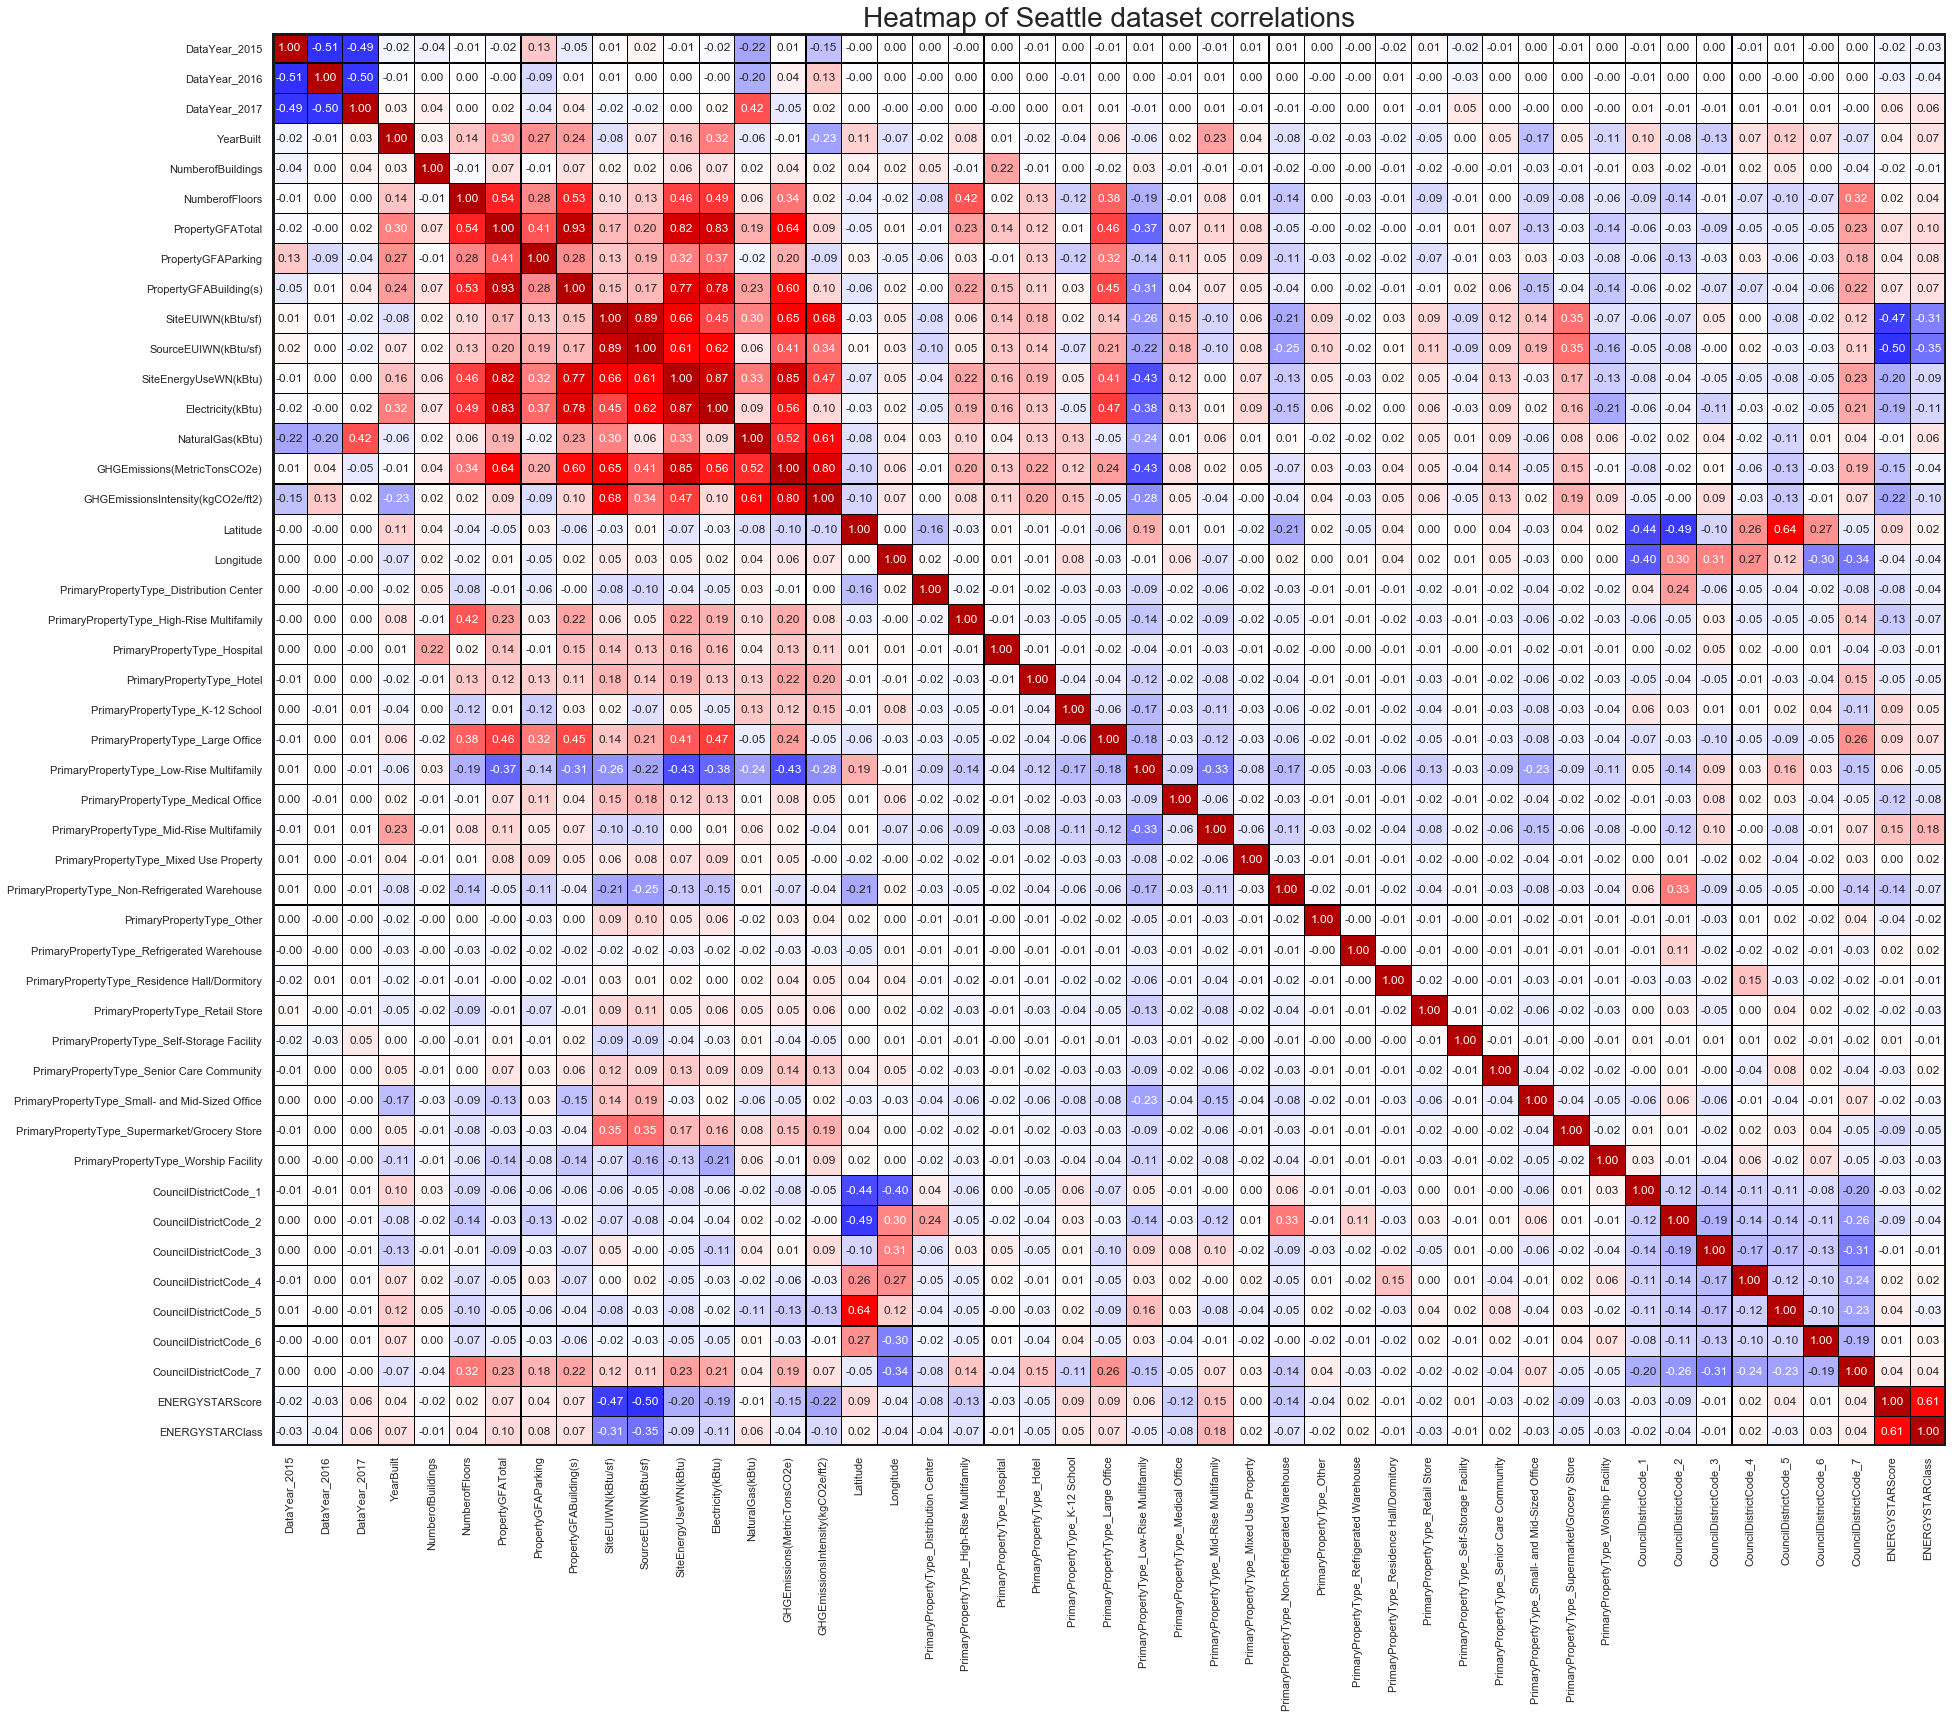

In [8]:
# Plotting Seattle correlation heatmap
CorrHeatmapPlot(df_seattle, 'Seattle')

#### Figure 1 | Heatmap of Seattle dataset correlations
A correlational heatmap, representing only the set of features that were retained after preparation. The target ENERGYSTARScore is shown to be negatively correlated with both SourceEUIWN (r2=-0.50) and SiteEUIWN (r2=-0.47). Among other interesting correlations, there seems to be a moderately positive correlation between NaturalGas usage and DataYear_2017, suggesting an increased usage of this energy source from 2015-2016 to 2017.

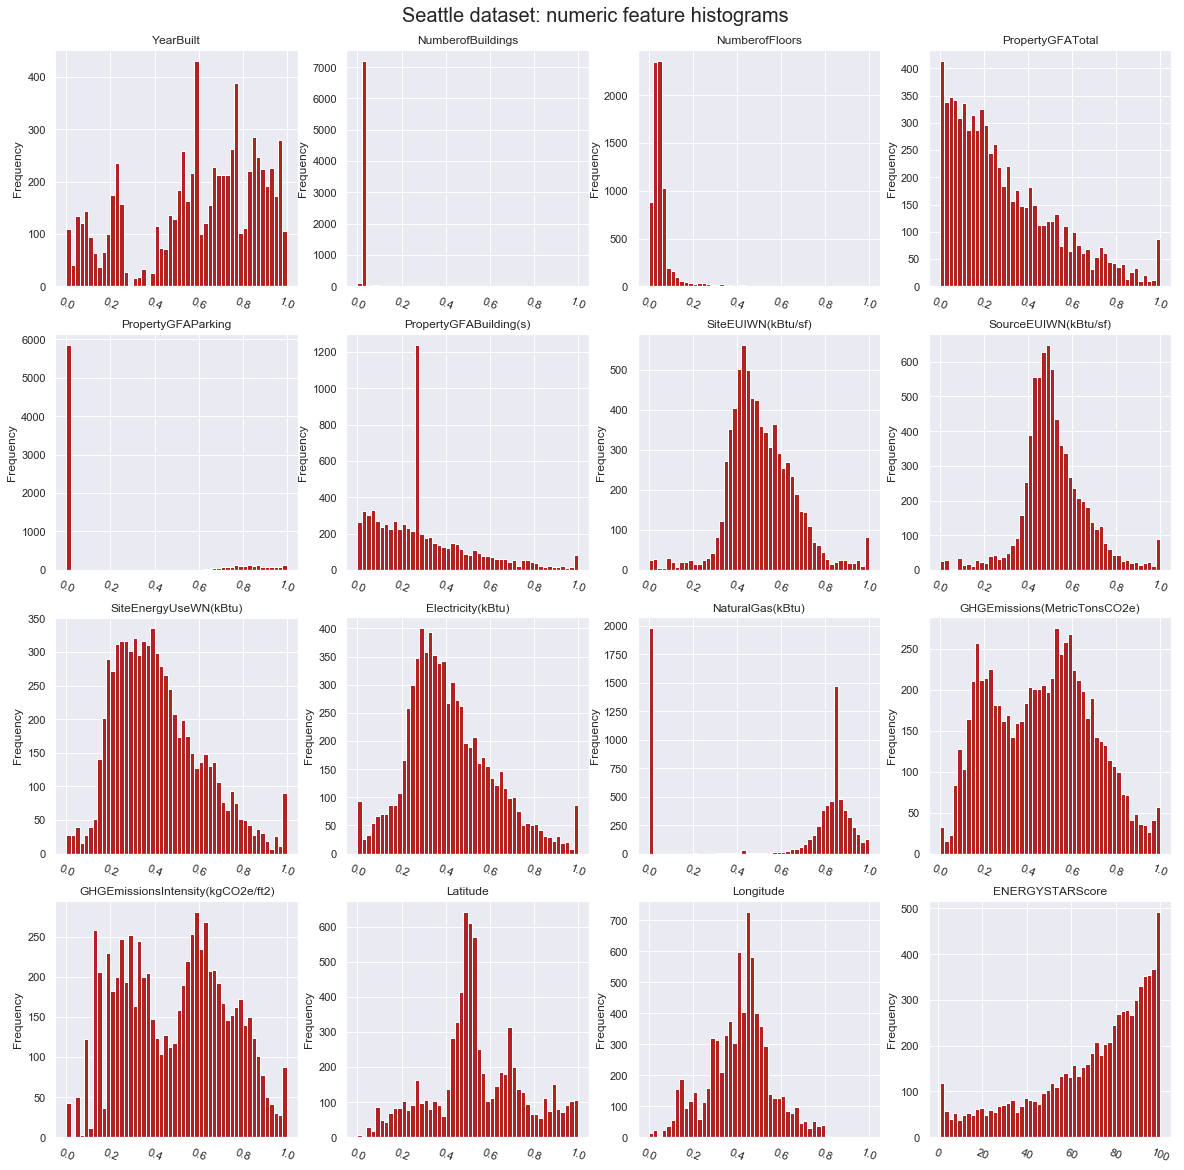

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count  7429.000000        7429.000000     7429.000000       7429.000000   
mean      0.600831           0.031588        0.051468          0.290530   
std       0.273340           0.020693        0.060429          0.233063   
min       0.000000           0.000000        0.000000          0.000000   
25%       0.461538           0.030303        0.030303          0.106727   
50%       0.658120           0.030303        0.040404          0.228265   
75%       0.829060           0.030303        0.050505          0.423332   
max       1.000000           1.000000        1.000000          1.000000   

       PropertyGFAParking  PropertyGFABuilding(s)  SiteEUIWN(kBtu/sf)  \
count         7429.000000             7429.000000         7429.000000   
mean             0.175828                0.295546            0.507155   
std              0.342141                0.216959            0.151499   
min              0.000000                0.000000            0.000000   
25%              0.000000                0.129997            0.412304   
50%              0.000000                0.279594            0.487148   
75%              0.000000                0.397345            0.595263   
max              1.000000                1.000000            1.000000   

       SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  Electricity(kBtu)  \
count           7429.000000            7429.000000        7429.000000   
mean               0.515905               0.416194           0.417213   
std                0.147522               0.196985           0.195450   
min                0.000000               0.000000           0.000000   
25%                0.437903               0.265830           0.284065   
50%                0.498553               0.386123           0.385120   
75%                0.586286               0.535894           0.532991   
max                1.000000               1.000000           1.000000   

       NaturalGas(kBtu)  GHGEmissions(MetricTonsCO2e)  \
count       7429.000000                   7429.000000   
mean           0.614295                      0.460577   
std            0.376755                      0.227402   
min            0.000000                      0.000000   
25%            0.000000                      0.260256   
50%            0.822374                      0.470095   
75%            0.858655                      0.626758   
max            1.000000                      1.000000   

       GHGEmissionsIntensity(kgCO2e/ft2)     Latitude    Longitude  \
count                        7429.000000  7429.000000  7429.000000   
mean                            0.492504     0.539087     0.411653   
std                             0.238287     0.206449     0.141857   
min                             0.000000     0.000000     0.000000   
25%                             0.285126     0.440106     0.325117   
50%                             0.517004     0.514572     0.423108   
75%                             0.676512     0.679463     0.492532   
max                             1.000000     1.000000     1.000000   

       ENERGYSTARScore  
count      7429.000000  
mean         69.063804  
std          26.550558  
min           1.000000  
25%          54.000000  
50%          77.000000  
75%          91.000000  
max         100.000000

In [9]:
# Plotting Seattle numeric feature histograms
seacols = list(df_seattle.columns)
sea_catcols = [col for col in seacols if col.startswith('DataYear') 
                                      or col.startswith('PrimaryPropertyType') 
                                      or col.startswith('CouncilDistrictCode') 
                                      or col == 'ENERGYSTARClass']
sea_numeric = df_seattle.drop(sea_catcols, axis=1)
MultiHistPlot(sea_numeric, 'Seattle', (4,4), (20,20))

#### Figure 2 | Numeric feature histograms and summary statistics for Seattle dataset
During initial data preparation, all numeric features were standardized to a range of 0 to 1. Some features were additionally winsorized, reducing the effect of outliers. However, while some features such as Site and Source EUIWN exhibit normal distributions, other features, such as NumberofBuildings and NumberofFloors, are heavily skewed.

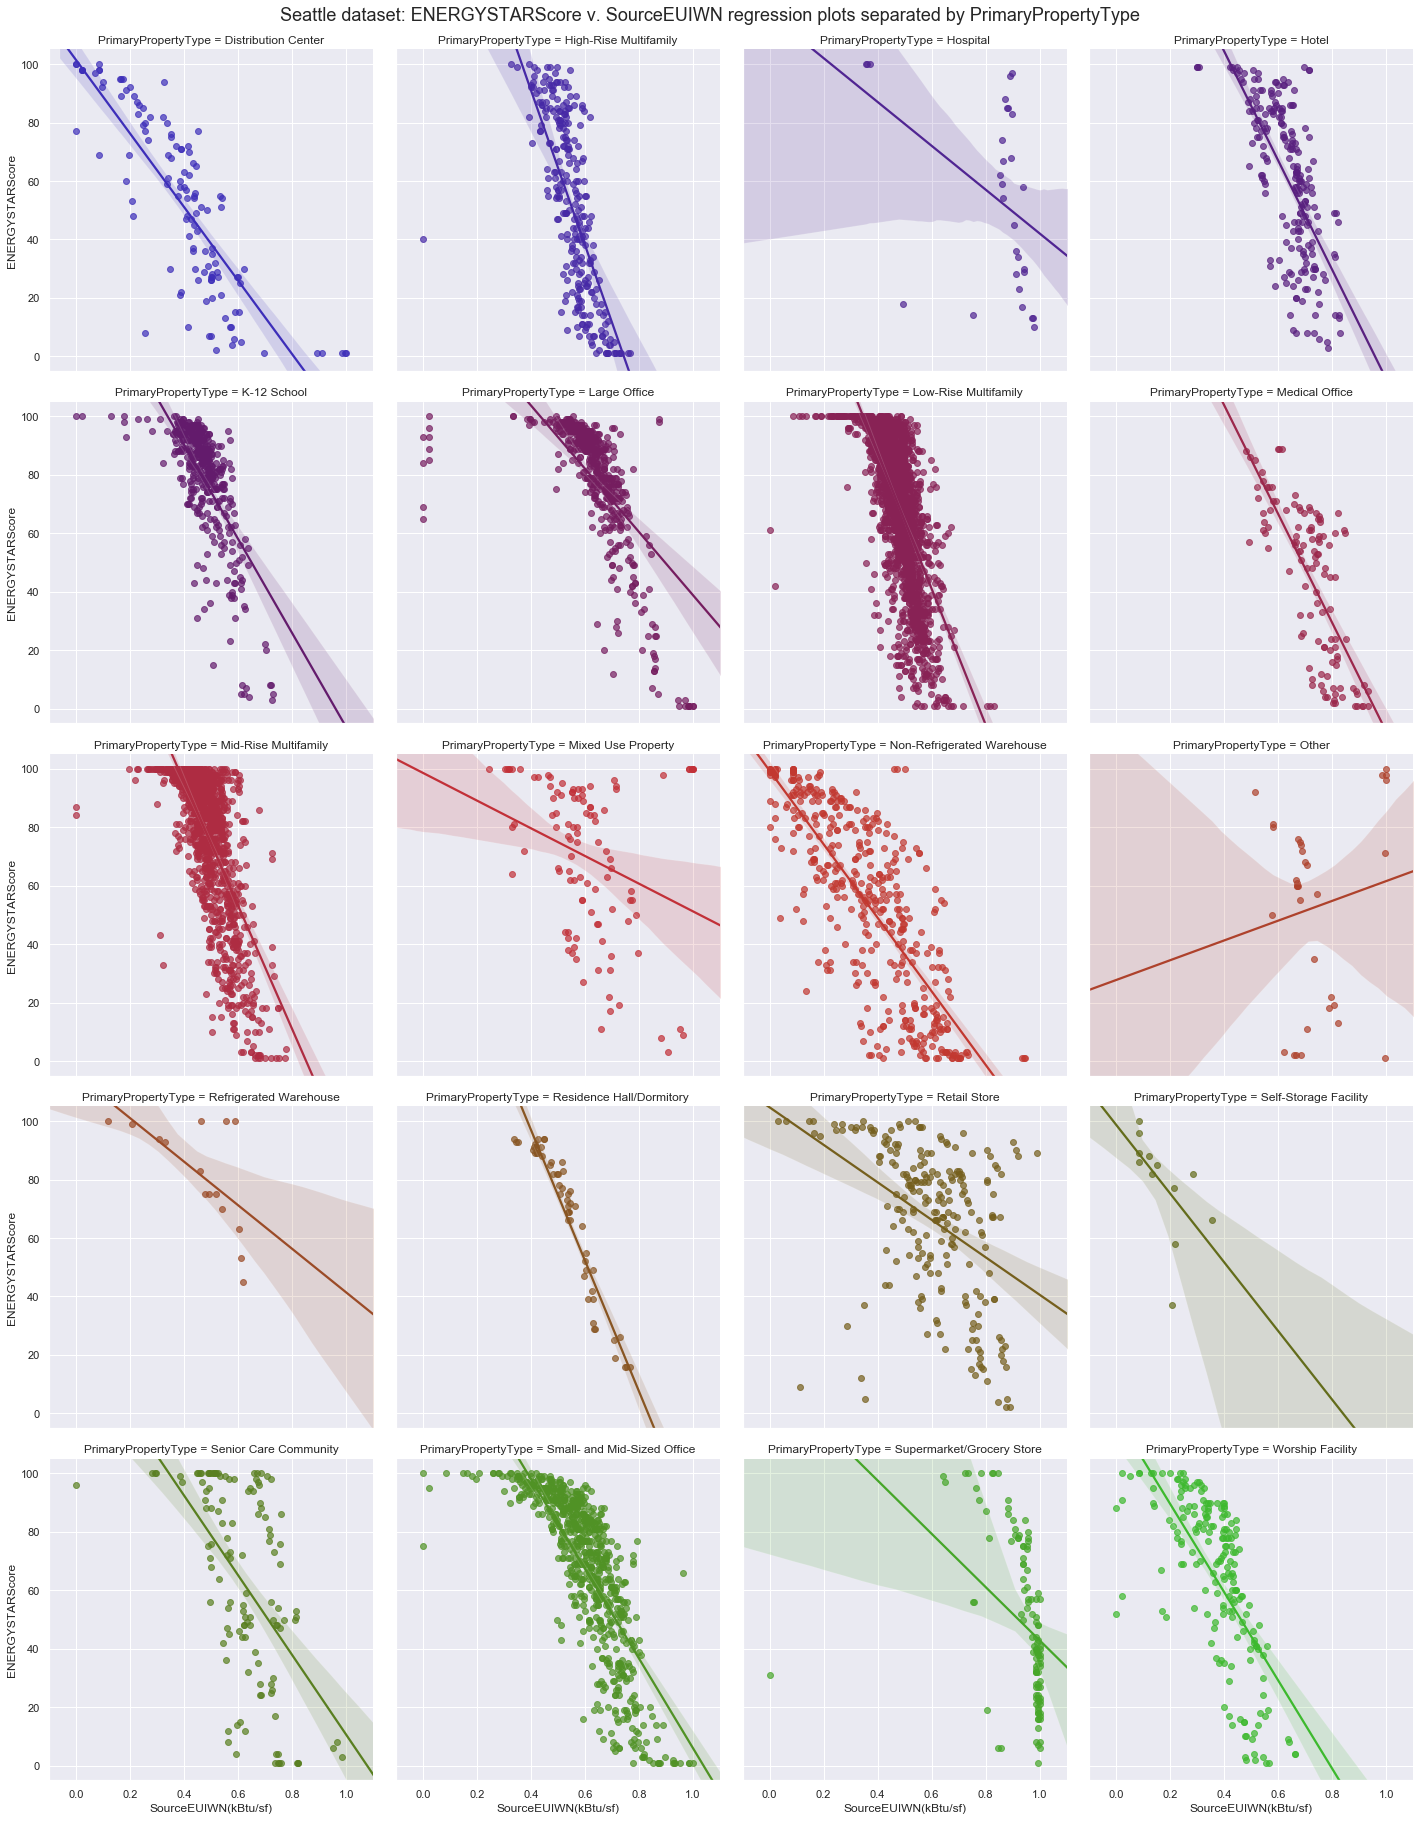

Distribution Center  High-Rise Multifamily   Hospital       Hotel  \
N               119.000000             271.000000  29.000000  212.000000   
R-sqr             0.691029               0.516947   0.190443    0.470535   

       K-12 School  Large Office  Low-Rise Multifamily  Medical Office  \
N       395.000000    475.000000            2473.00000      117.000000   
R-sqr     0.463642      0.422011               0.47791        0.556605   

       Mid-Rise Multifamily  Mixed Use Property  Non-Refrigerated Warehouse  \
N               1336.000000          104.000000                  420.000000   
R-sqr              0.488693            0.088637                    0.605823   

           Other  Refrigerated Warehouse  Residence Hall/Dormitory  \
N      33.000000               15.000000                 54.000000   
R-sqr   0.020704                0.386127                  0.904149   

       Retail Store  Self-Storage Facility  Senior Care Community  \
N        227.000000              12.000000             123.000000   
R-sqr      0.183031               0.346554               0.322611   

       Small- and Mid-Sized Office  Supermarket/Grocery Store  \
N                         710.0000                  113.00000   
R-sqr                       0.6114                    0.15802   

       Worship Facility  
N            191.000000  
R-sqr          0.474686

In [10]:
# Plotting regressions for ENERGYSTARScore v. SourceEUIWN across PrimaryPropertyTypes for Seattle
MultiRegPlot(df_seattle, 'Seattle')

#### Figure 3 | Regression plots and report for ENERGYSTARScore v. SourceEUIWN by PrimaryPropertyType for Seattle dataset
Low-Rise Multifamily (N=2473), Mid-Rise Multifamily (N=1336), and Small- and Mid Size Office (N=710) are the most well represented PrimaryPropertyTypes, but there is a considerable number of entries spread across all types. Addtionally, there is a distinct 'S' shaped (Sigmoid) distribution to the data for the more common types, though the degree of curvature varies considerably.

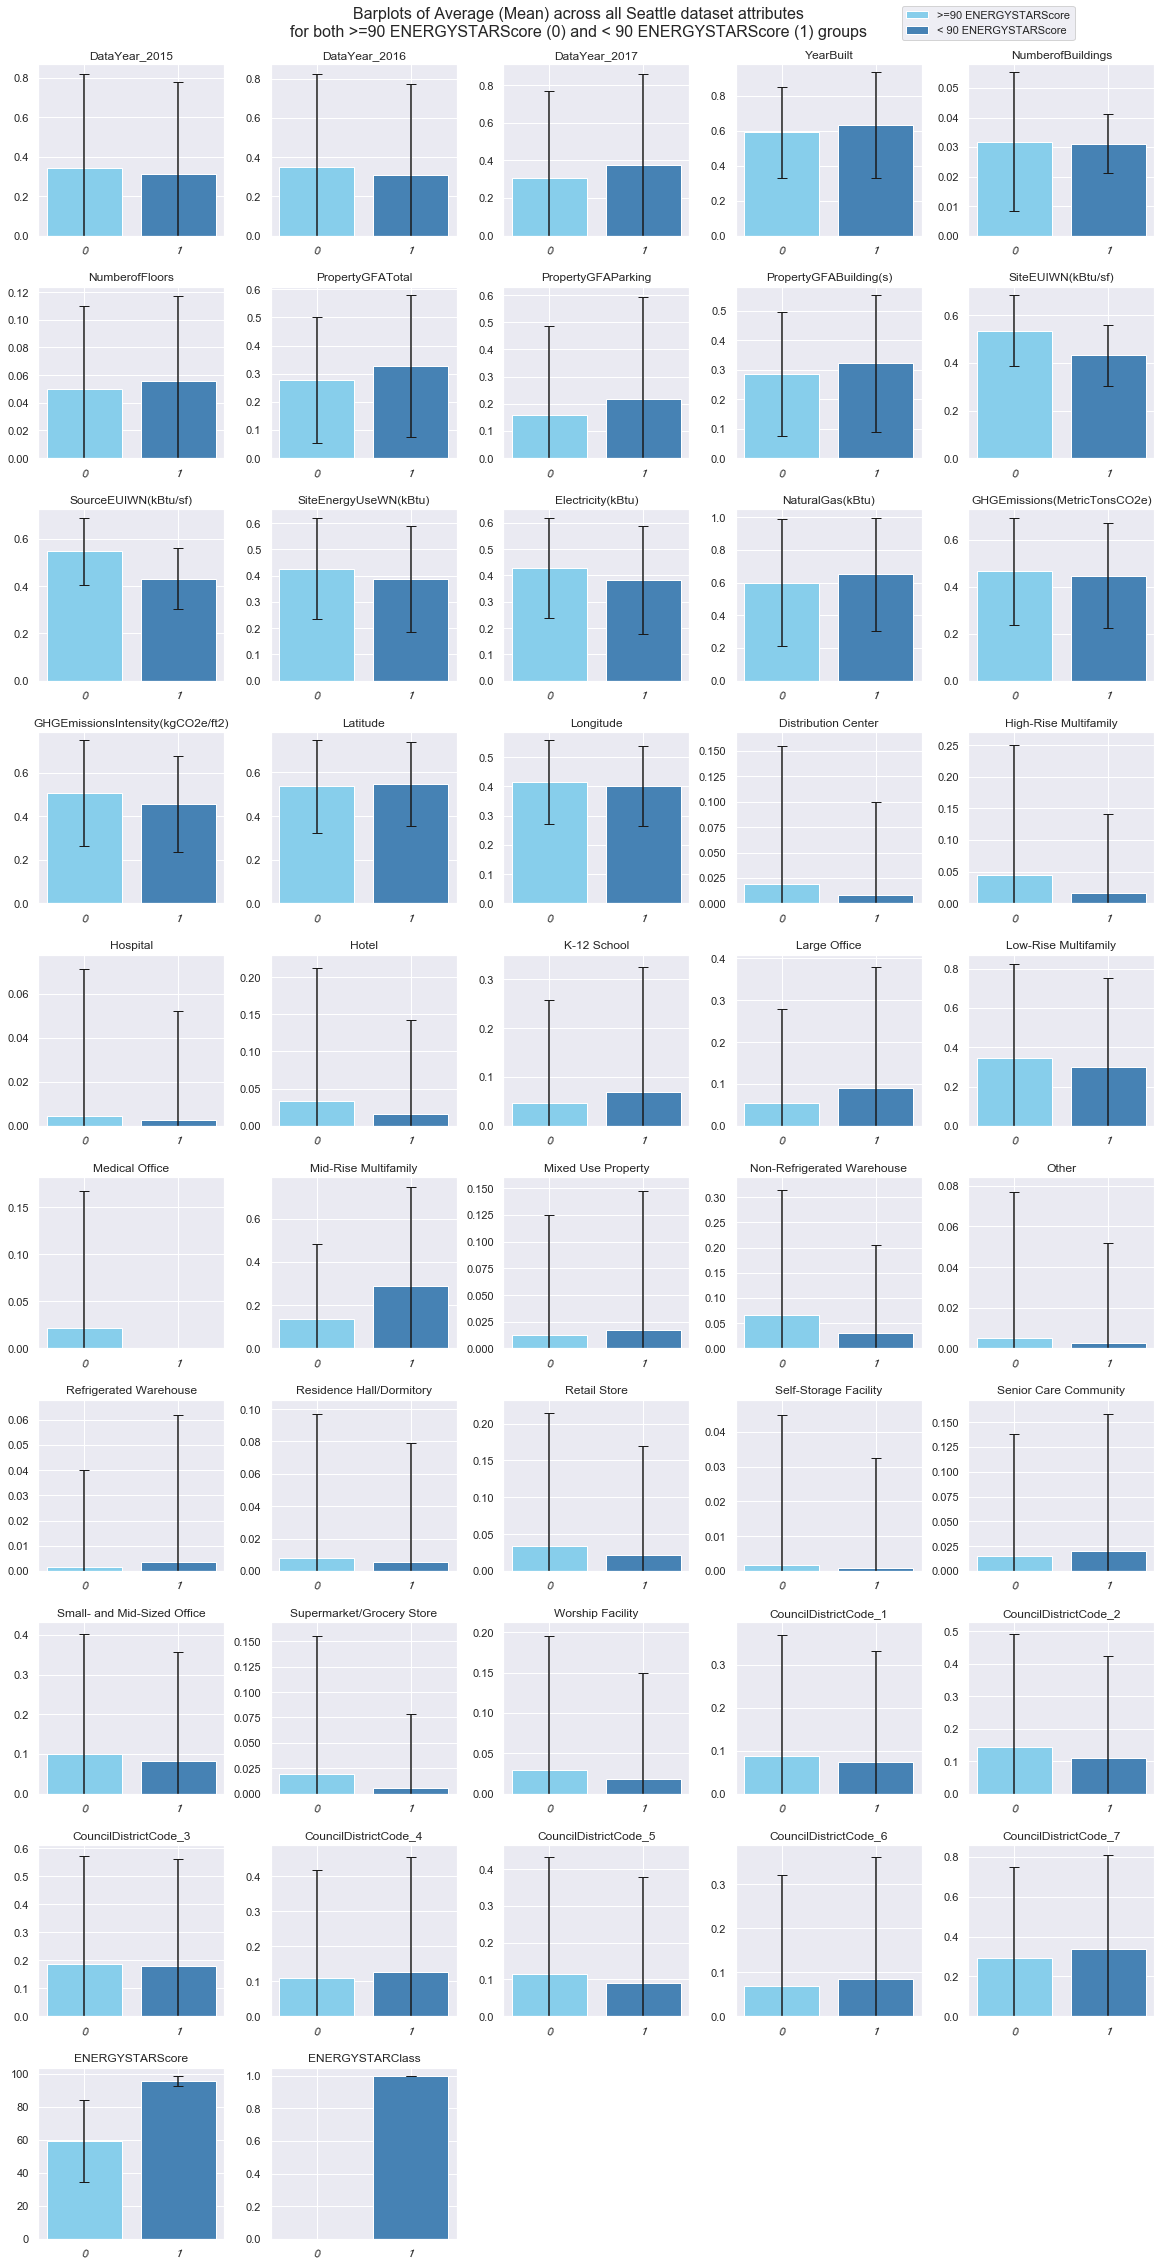

DataYear_2015 DataYear_2016 DataYear_2017   YearBuilt  \
0_mean      0.343461      0.348092      0.308448    0.589265   
0_std       0.474908      0.476409      0.461895    0.261475   
1_mean      0.313639      0.310684      0.375677     0.63157   
1_std       0.464086      0.462888      0.484416    0.300533   
p-val     0.01523521    0.00237634    0.00000004  0.00000000   
t-stat        2.4273        3.0397       -5.5166     -5.9593   

       NumberofBuildings NumberofFloors PropertyGFATotal PropertyGFAParking  \
0_mean         0.0317738        0.04991         0.276654           0.159623   
0_std          0.0234838      0.0598479         0.223909           0.328278   
1_mean         0.0310938      0.0556078         0.327407           0.218896   
1_std          0.0100124      0.0617707          0.25218           0.373193   
p-val         0.20680514     0.00029076       0.00000000         0.00000000   
t-stat            1.2625        -3.6251          -8.4046            -6.6746   

       PropertyGFABuilding(s) SiteEUIWN(kBtu/sf) SourceEUIWN(kBtu/sf)  \
0_mean                 0.2856           0.535546             0.547565   
0_std                 0.21017           0.150041             0.141968   
1_mean               0.321979           0.431698             0.431758   
1_std                0.232036            0.12764             0.127664   
p-val              0.00000000         0.00000000           0.00000000   
t-stat                -6.4589            27.6532              32.1899   

       SiteEnergyUseWN(kBtu) Electricity(kBtu) NaturalGas(kBtu)  \
0_mean              0.427201          0.429848         0.600234   
0_std               0.193776          0.190015         0.386869   
1_mean               0.38694           0.38363         0.651667   
1_std               0.202431          0.205516         0.345771   
p-val             0.00000000        0.00000000       0.00000015   
t-stat                7.8840            9.1343          -5.2538   

       GHGEmissions(MetricTonsCO2e) GHGEmissionsIntensity(kgCO2e/ft2)  \
0_mean                     0.465603                          0.506558   
0_std                      0.228573                          0.243362   
1_mean                     0.447221                          0.455153   
1_std                      0.223768                          0.219976   
p-val                    0.00189620                        0.00000000   
t-stat                       3.1071                            8.3253   

          Latitude   Longitude PrimaryPropertyType_Distribution Center  \
0_mean    0.535965    0.415276                               0.0188959   
0_std     0.211982    0.143113                                 0.13617   
1_mean    0.547383    0.402022                              0.00837026   
1_std     0.190769    0.138036                               0.0911279   
p-val   0.03360183  0.00032996                              0.00127611   
t-stat     -2.1252      3.5922                                  3.2225   

       PrimaryPropertyType_High-Rise Multifamily PrimaryPropertyType_Hospital  \
0_mean                                 0.0442757                   0.00444609   
0_std                                   0.205726                    0.0665368   
1_mean                                 0.0157558                   0.00246184   
1_std                                    0.12456                     0.049568   
p-val                                 0.00000000                   0.22160592   
t-stat                                    5.8566                       1.2224   

       PrimaryPropertyType_Hotel PrimaryPropertyType_K-12 School  \
0_mean                 0.0331604                       0.0468692   
0_std                   0.179072                        0.211378   
1_mean                 0.0162482                       0.0699163   
1_std                    0.12646                        0.255069   
p-val                 0.00009485                      0.00007902   
t-stat         

In [11]:
# Comparing ENERGYSTARClass 0 and 1 samples across all Seattle dataset features 
df_sea_0 = df_seattle[df_seattle['ENERGYSTARClass'] == 0]
df_sea_1 = df_seattle[df_seattle['ENERGYSTARClass'] == 1]

BarplotTtestMultiDf(df_sea_0, df_sea_1, 'Seattle',
                    ['0', '>=90 ENERGYSTARScore'], ['1', '< 90 ENERGYSTARScore'],
                    figsize=(20,40), subplot_dim=(10,5), subplot_adj=(0.25, 0.3),
                    legend_adj=(0.75, 0.787))

#### Figure 4 | ENERGYSTARClass barplots and accompanying t-test report across all features for Seattle dataset
The most significant differences were found between SourceEUIWN (t=32.19), SiteEUIWN (t=27.65), and PrimaryPropertyType_Mid-Rise Multifamily (t=-15.48) features.

### Chicago Dataset Exploration

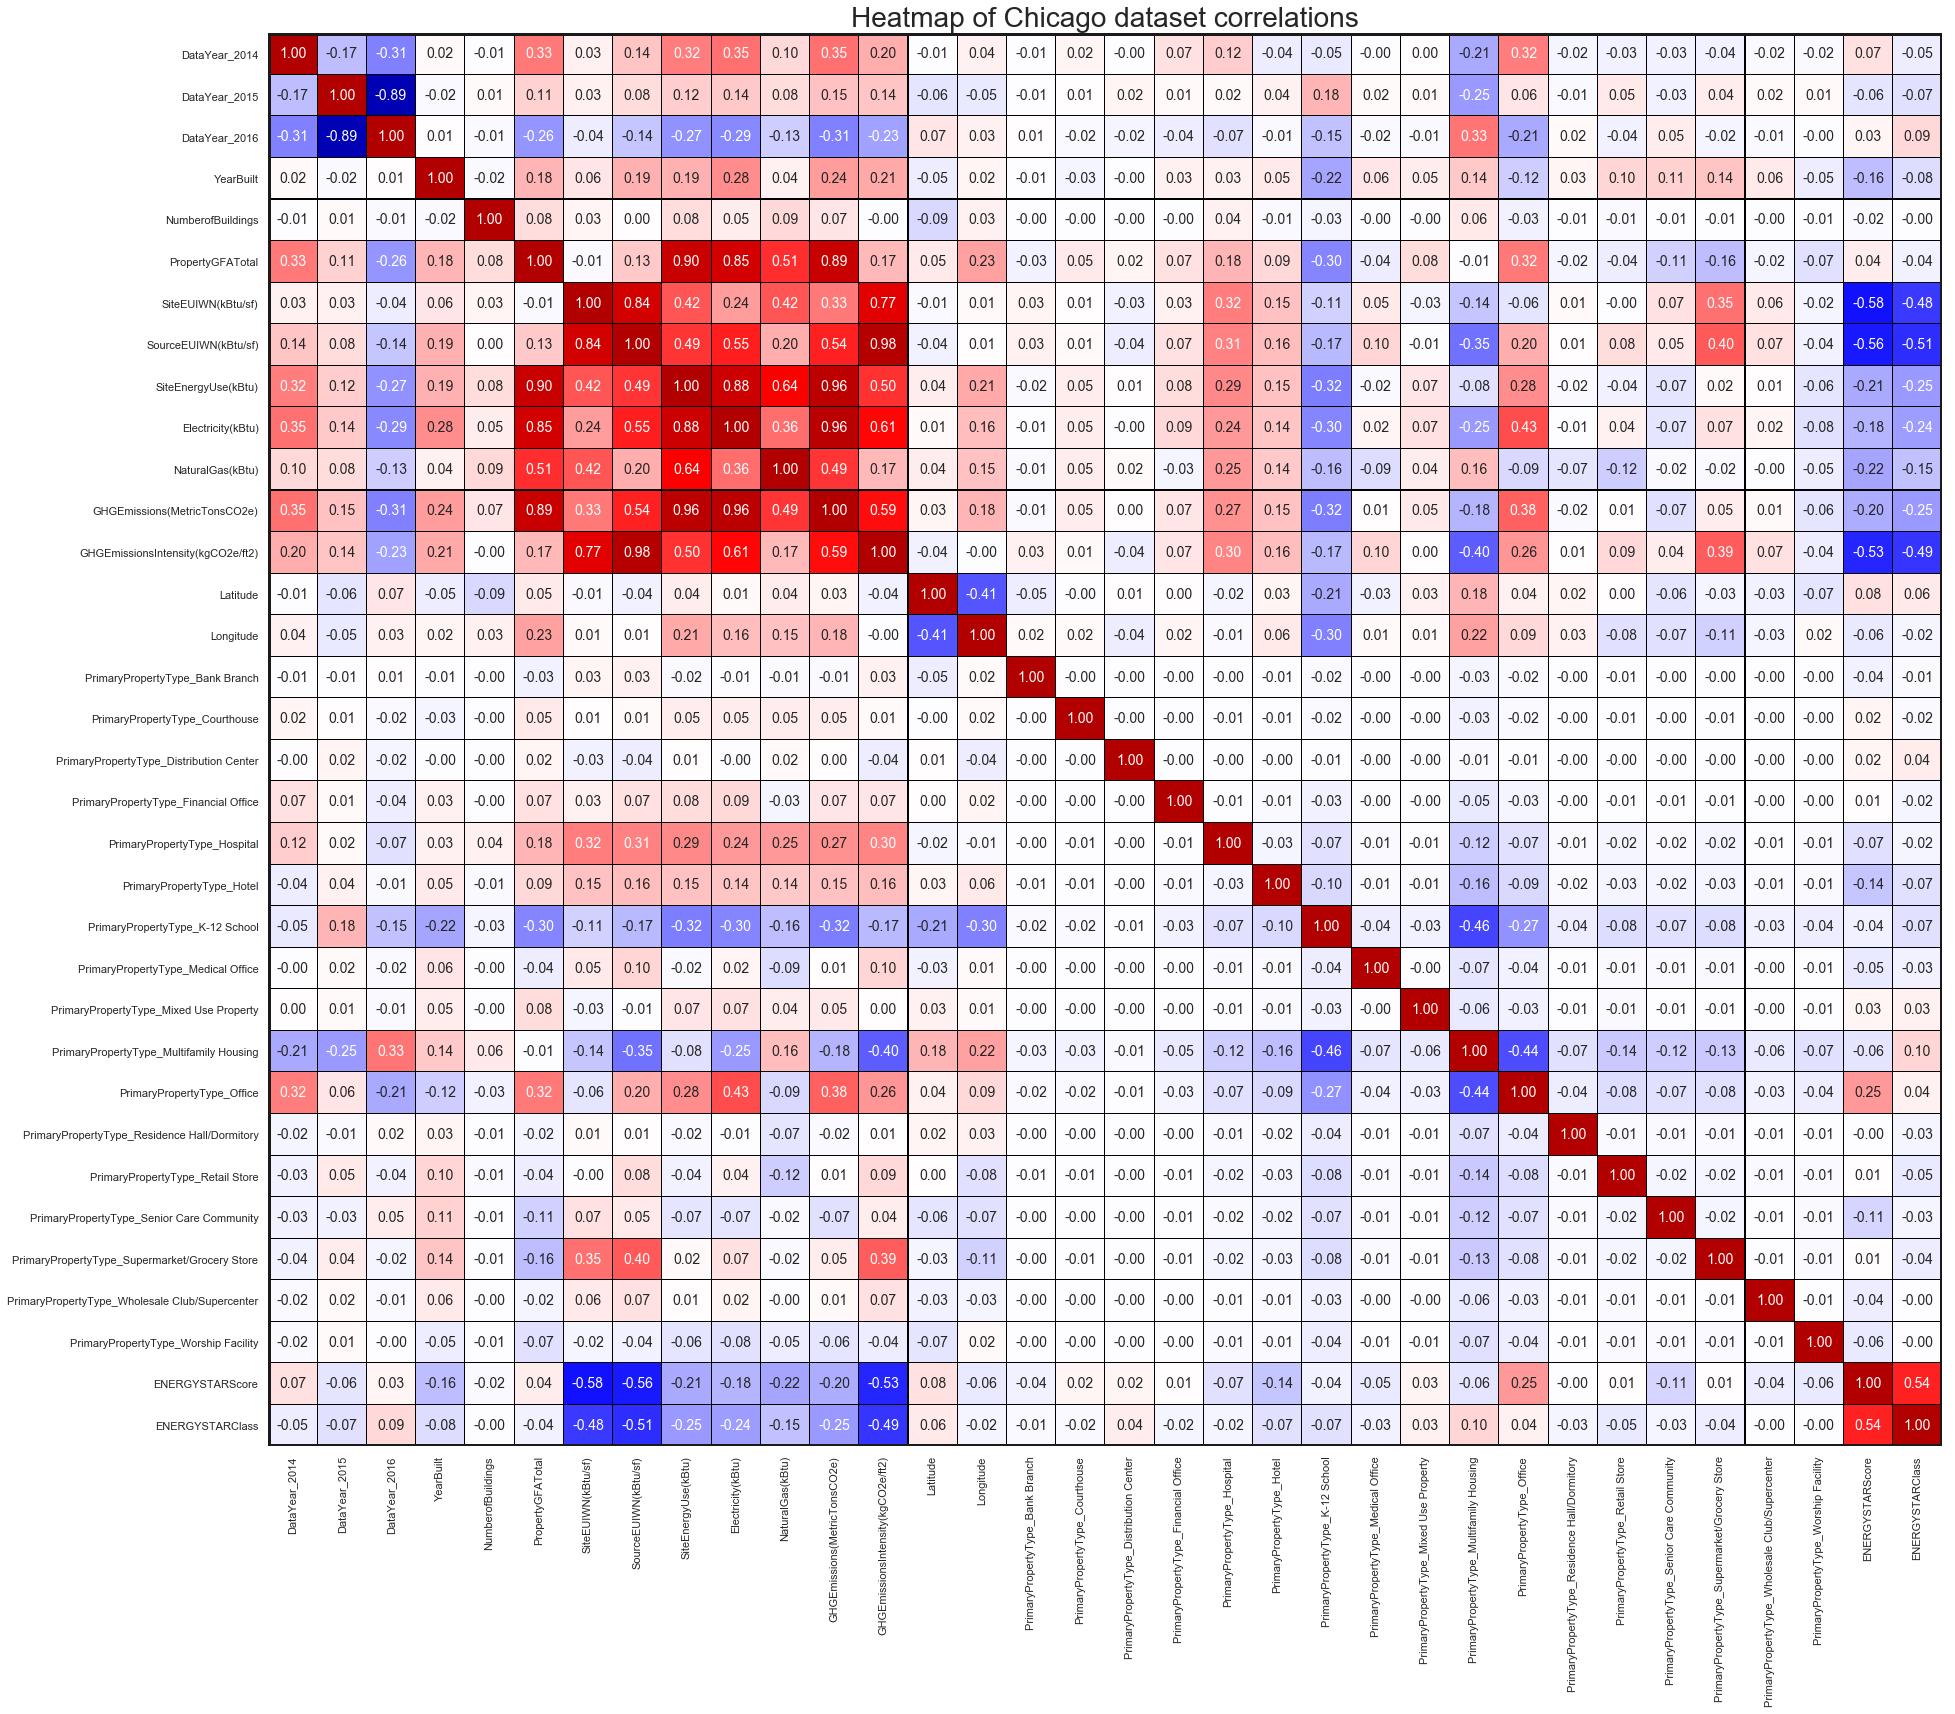

In [12]:
# Plotting Chicago correlation heatmap
CorrHeatmapPlot(df_chicago, 'Chicago', annotsize=14)

#### Figure 5 | Heatmap of Chicago dataset correlations
As with the Seattle dataset, this correlational heatmap represents only the set of features that were retained after preparation. ENERGYSTARScore is negatively correlated with SourceEUIWN (-0.56, v. -0.50 for Seattle dataset) and SiteEUIWN (-0.58, v. -0.47 Seattle) as well as GHGEmissionsIntensity (-0.53, v. -0.22 Seattle).

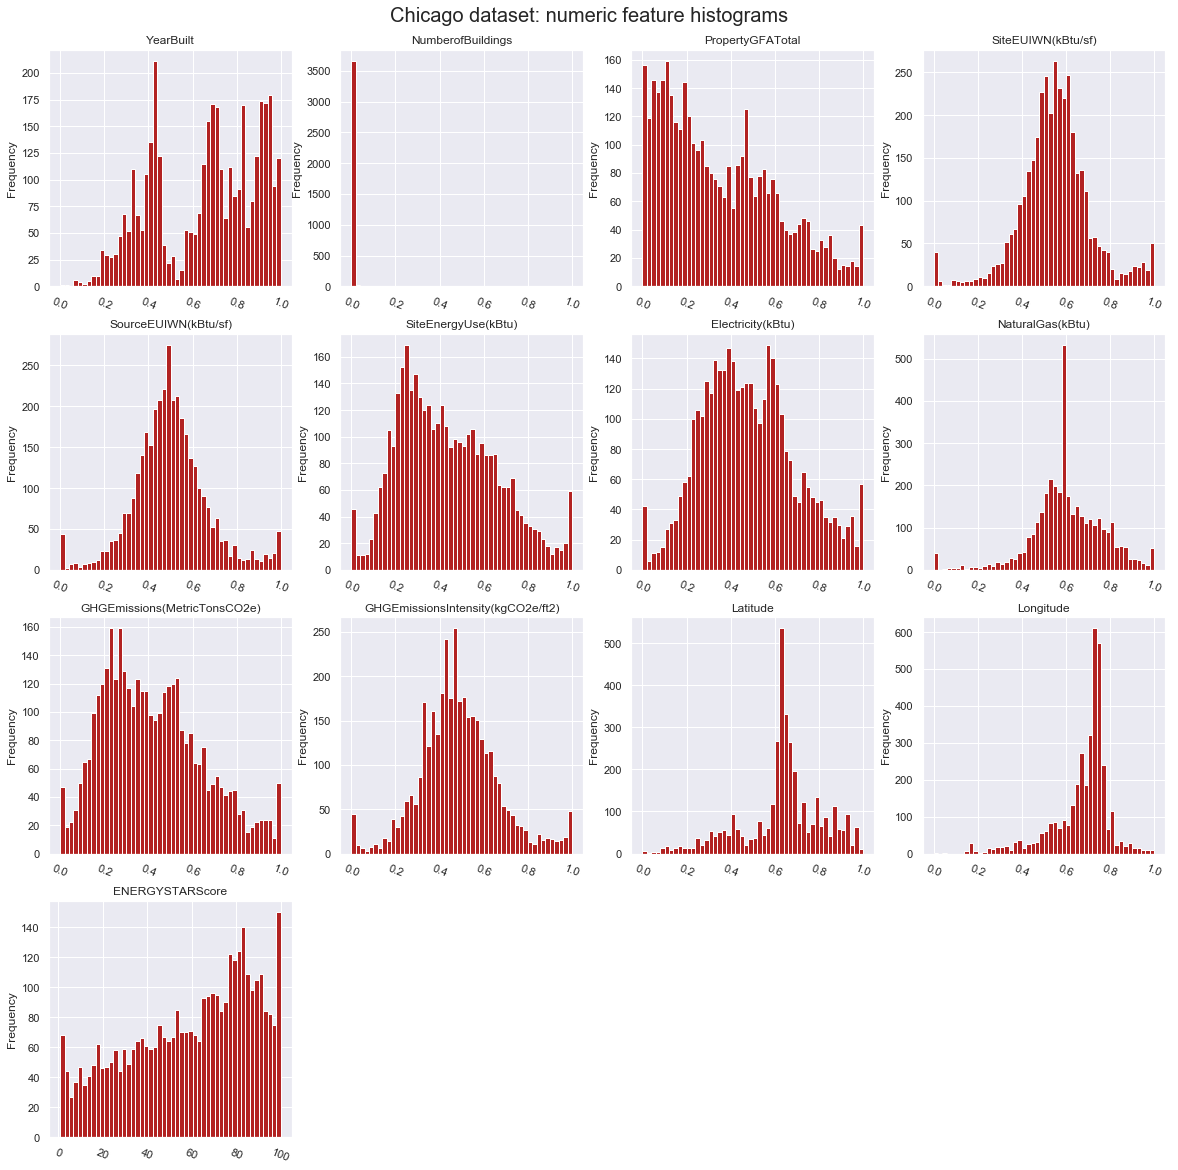

YearBuilt  NumberofBuildings  PropertyGFATotal  SiteEUIWN(kBtu/sf)  \
count  3700.000000        3700.000000       3700.000000         3700.000000   
mean      0.655551           0.001616          0.347231            0.551113   
std       0.233134           0.025395          0.253778            0.161082   
min       0.000000           0.000000          0.000000            0.000000   
25%       0.429487           0.000000          0.127259            0.466608   
50%       0.698718           0.000000          0.293640            0.551289   
75%       0.865385           0.000000          0.528750            0.629661   
max       1.000000           1.000000          1.000000            1.000000   

       SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  Electricity(kBtu)  \
count           3700.000000          3700.000000        3700.000000   
mean               0.499506             0.437426           0.481489   
std                0.169391             0.222386           0.214799   
min                0.000000             0.000000           0.000000   
25%                0.400751             0.259273           0.325041   
50%                0.492658             0.406079           0.463304   
75%                0.583833             0.593004           0.616134   
max                1.000000             1.000000           1.000000   

       NaturalGas(kBtu)  GHGEmissions(MetricTonsCO2e)  \
count       3700.000000                   3700.000000   
mean           0.606904                      0.419560   
std            0.162497                      0.226169   
min            0.000000                      0.000000   
25%            0.522514                      0.240793   
50%            0.599033                      0.389898   
75%            0.708645                      0.564321   
max            1.000000                      1.000000   

       GHGEmissionsIntensity(kgCO2e/ft2)     Latitude    Longitude  \
count                        3700.000000  3700.000000  3700.000000   
mean                            0.486377     0.630619     0.672593   
std                             0.177168     0.182016     0.133337   
min                             0.000000     0.000000     0.000000   
25%                             0.379466     0.579968     0.636872   
50%                             0.474748     0.640165     0.715013   
75%                             0.585556     0.734676     0.747531   
max                             1.000000     1.000000     1.000000   

       ENERGYSTARScore  
count      3700.000000  
mean         59.466757  
std          27.822376  
min           1.000000  
25%          38.000000  
50%          65.000000  
75%          83.000000  
max         100.000000

In [13]:
# Plotting Chicago numeric feature histograms
chicols = list(df_chicago.columns)
chi_catcols = [col for col in chicols if col.startswith('DataYear') 
                                      or col.startswith('PrimaryPropertyType') 
                                      or col == 'ENERGYSTARClass']
chi_numeric = df_chicago.drop(chi_catcols, axis=1)
MultiHistPlot(chi_numeric, 'Chicago', (4,4), (20,20))

#### Figure 6 | Numeric feature histograms and summary statistics for Chicago dataset
During initial data preparation, all numeric features were standardized to a range of 0 to 1. Some features were additionally winsorized, reducing the effect of outliers. Unlike Seattle's, Chicago's data did not include NumberofFloors, ProprtyGFAParking, PropertyGFABuilding(s) features. As such, only NumberofBuildings suffers from a high degree of skew.  

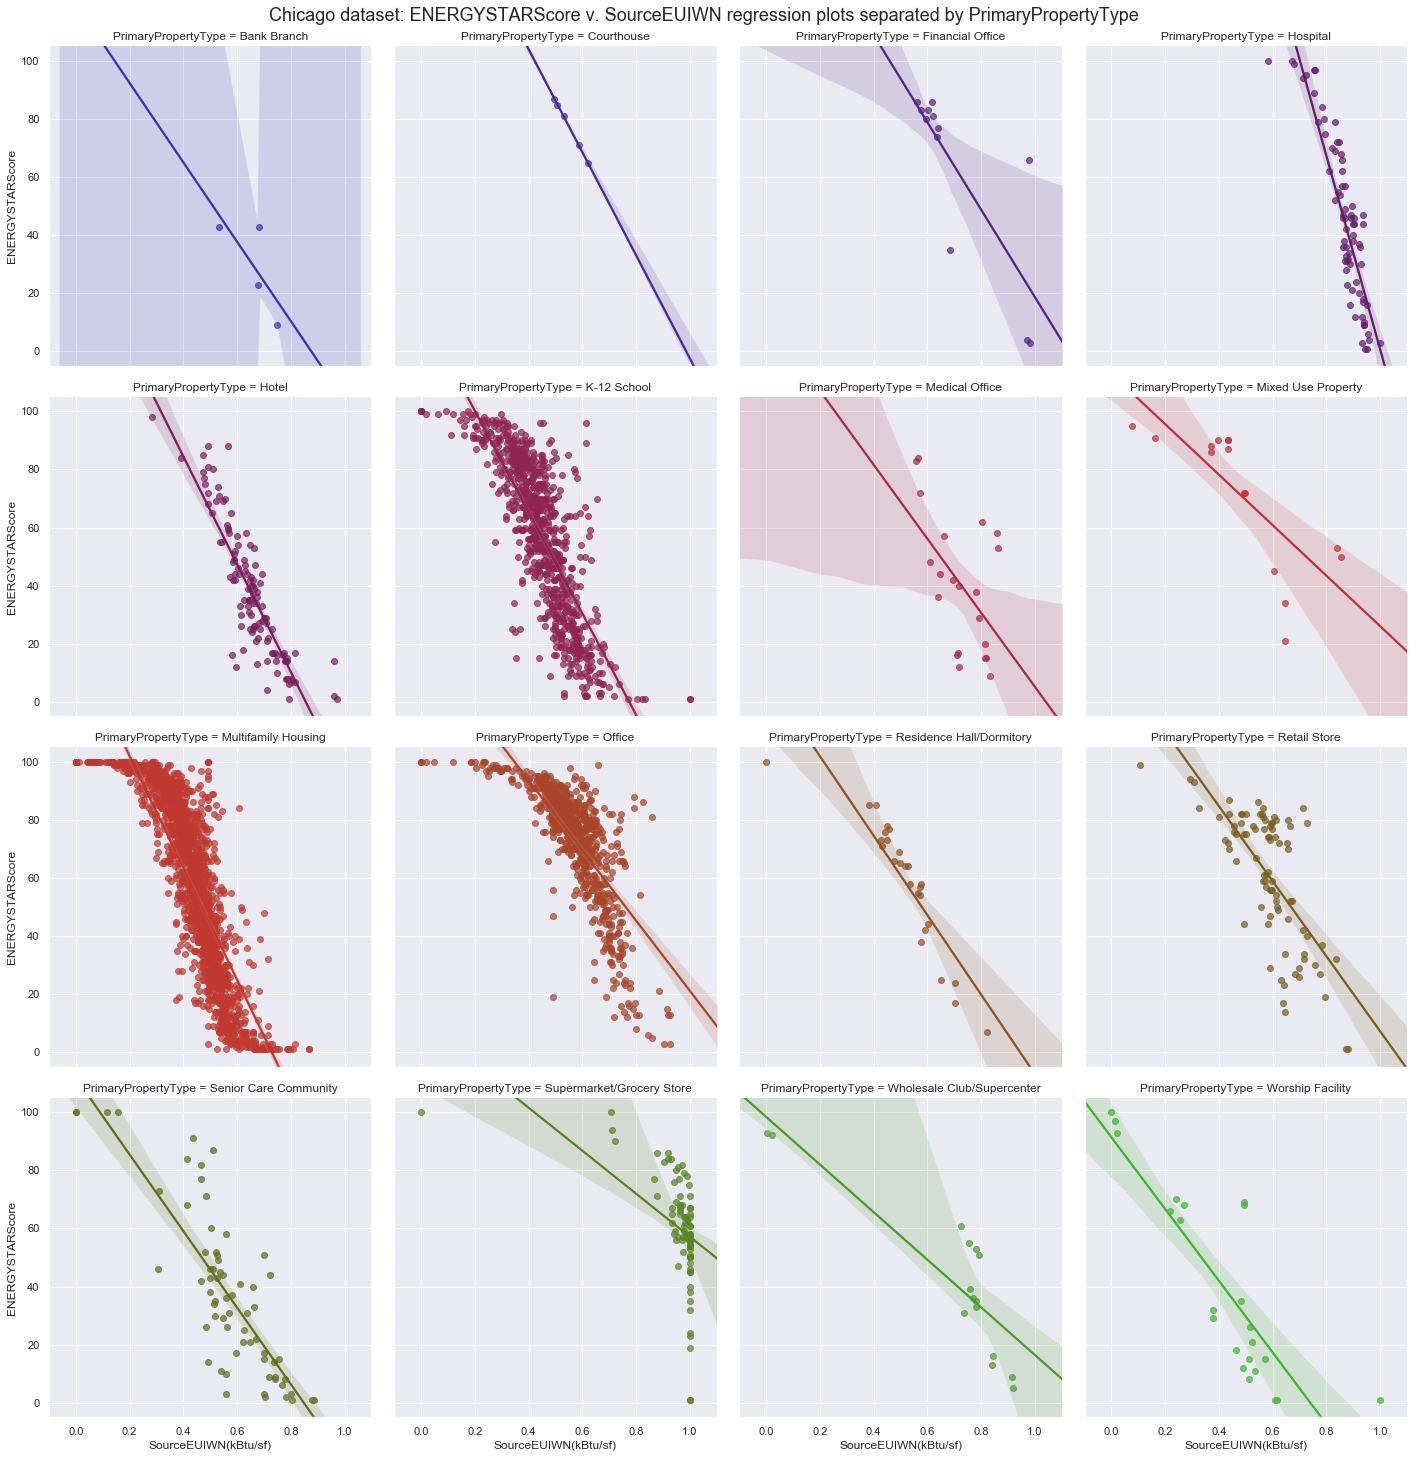

Bank Branch  Courthouse  Financial Office   Hospital       Hotel  \
N         4.000000    5.000000         12.000000  73.000000  120.000000   
R-sqr     0.559867    0.999304          0.648824   0.791946    0.761859   

       K-12 School  Medical Office  Mixed Use Property  Multifamily Housing  \
N       806.000000       21.000000           15.000000          1591.000000   
R-sqr     0.644494        0.292507            0.592942             0.700164   

           Office  Residence Hall/Dormitory  Retail Store  \
N      752.000000                 26.000000     88.000000   
R-sqr    0.574184                  0.804228      0.490892   

       Senior Care Community  Supermarket/Grocery Store  \
N                  67.000000                  81.000000   
R-sqr               0.680878                   0.238072   

       Wholesale Club/Supercenter  Worship Facility  
N                       15.000000         23.000000  
R-sqr                    0.746154          0.721518

In [14]:
# Plotting regressions for ENERGYSTARScore v. SourceEUIWN across PrimaryPropertyTypes for Chicago
MultiRegPlot(df_chicago, 'Chicago')

#### Figure 7 | Regression plots and report for ENERGYSTARScore v. SourceEUIWN by PrimaryPropertyType for Chicago dataset
Multifamily Housing (N=1591), K-12 School (N=806), and Office (N=752) represent most of the entries, with the next largest type being Hotel (N=120). The property groupings also differ slightly from that of the Seattle dataset, with multifamily housing and offices being grouped into 2, rather than 5 property types. This lack of diversity could perhaps benefit the model's accuracy, as the entries are likely more homogenous overall.

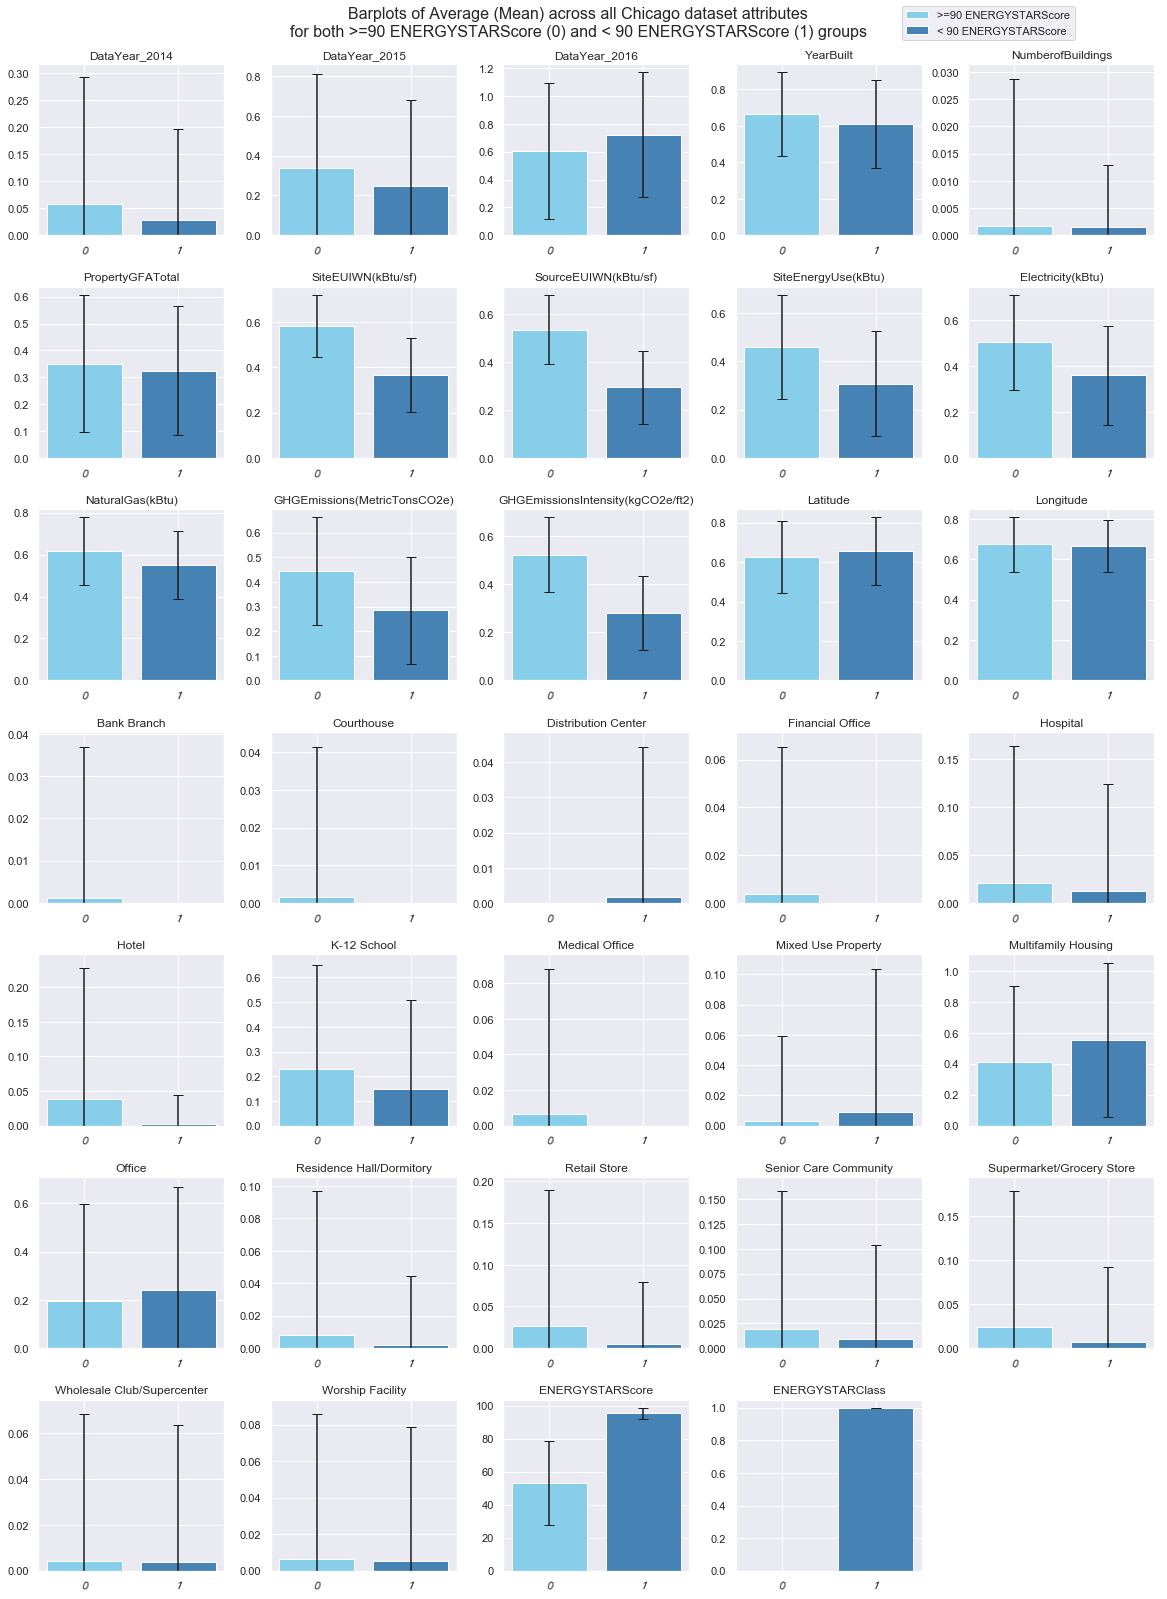

DataYear_2014 DataYear_2015 DataYear_2016   YearBuilt  \
0_mean     0.0584684      0.337782       0.60375    0.663289   
0_std       0.234664      0.473029      0.489195    0.230656   
1_mean     0.0289331       0.24774      0.723327    0.611513   
1_std        0.16777      0.432091      0.447758     0.24231   
p-val     0.00460698    0.00002979    0.00000009  0.00000141   
t-stat        2.8350        4.1803       -5.3666      4.8311   

       NumberofBuildings PropertyGFATotal SiteEUIWN(kBtu/sf)  \
0_mean        0.00163614         0.351329           0.583718   
0_std          0.0271142         0.255881           0.136819   
1_mean        0.00150052         0.323916            0.36557   
1_std          0.0114667         0.240362           0.163214   
p-val         0.90781137       0.01912720         0.00000000   
t-stat            0.1158           2.3441            33.5364   

       SourceEUIWN(kBtu/sf) SiteEnergyUse(kBtu) Electricity(kBtu)  \
0_mean             0.535598            0.460302          0.503036   
0_std              0.145003            0.215196          0.207263   
1_mean             0.294119            0.307244          0.358868   
1_std              0.150853            0.217978          0.215959   
p-val            0.00000000          0.00000000        0.00000000   
t-stat              35.8971             15.3954           14.9899   

       NaturalGas(kBtu) GHGEmissions(MetricTonsCO2e)  \
0_mean         0.616914                     0.443176   
0_std          0.160571                     0.219301   
1_mean         0.549936                     0.285166   
1_std          0.161796                     0.217735   
p-val        0.00000000                   0.00000000   
t-stat           9.0361                      15.6429   

       GHGEmissionsIntensity(kgCO2e/ft2)    Latitude   Longitude  \
0_mean                          0.522925    0.626406    0.673719   
0_std                           0.154321     0.18336    0.134168   
1_mean                          0.278385    0.654595    0.666187   
1_std                           0.153799    0.172379    0.128435   
p-val                         0.00000000  0.00077747  0.22059019   
t-stat                           34.3839     -3.3635      1.2252   

       PrimaryPropertyType_Bank Branch PrimaryPropertyType_Courthouse  \
0_mean                      0.00127105                     0.00158881   
0_std                        0.0356348                      0.0398346   
1_mean                               0                              0   
1_std                                0                              0   
p-val                       0.40169588                     0.34838975   
t-stat                          0.8387                         0.9378   

       PrimaryPropertyType_Distribution Center  \
0_mean                                       0   
0_std                                        0   
1_mean                              0.00180832   
1_std                                0.0425243   
p-val                               0.01703417   
t-stat                                 -2.3870   

       PrimaryPropertyType_Financial Office PrimaryPropertyType_Hospital  \
0_mean                           0.00381316                    0.0209724   
0_std                             0.0616427                     0.143314   
1_mean                                    0                    0.0126582   
1_std                                     0                     0.111896   
p-val                            0.14588956                   0.19488214   
t-stat                               1.4545                       1.2965   

       PrimaryPropertyType_Hotel PrimaryPropertyType_K-12 School  \
0_mean                 0.0378138                        0.229743   
0_std                   0.190776                        0.420734   
1_mean                0.00180832                         0.15009   
1_std                  0.0425243                        0.357483   
p-val              

In [15]:
# Comparing ENERGYSTARClass 0 and 1 samples across all Chicago dataset features 
df_chi_0 = df_chicago[df_chicago['ENERGYSTARClass'] == 0]
df_chi_1 = df_chicago[df_chicago['ENERGYSTARClass'] == 1]

BarplotTtestMultiDf(df_chi_0, df_chi_1, 'Chicago',
                    ['0', '>=90 ENERGYSTARScore'], ['1', '< 90 ENERGYSTARScore'],
                    figsize=(20,40), subplot_dim=(10,5), subplot_adj=(0.25,0.3),
                    legend_adj=(0.75,0.555))

#### Figure 8 | ENERGYSTARClass barplots and accompanying t-test report across all features for Chicago dataset
The most significant differences were found between SourceEUIWN (t=35.90, v. 32.19 Seattle), GHGEmissionsIntensity (t=34.38), SiteEUIWN (t=33.54 v. 27.65 Seattle), GHGEmissions (t=15.64), SiteEnergyUse (t=15.39), and Electricity (t=14.99) features.

## Feature Engineering and Selection

In [16]:
# Obtaining pre-normalization datasets for feature engineering
file_seattle_pre = ('https://raw.githubusercontent.com'
                    '/connor1higgins/Projects/master/UWDataScience/PartIII/'
                    'Energy_Benchmarking_Seattle_pre_norm_and_enc.csv')
file_chicago_pre = ('https://raw.githubusercontent.com'
                    '/connor1higgins/Projects/master/UWDataScience/PartIII/'
                    'Energy_Benchmarking_Chicago_pre_norm_and_enc.csv')

# Reading in both pre-normalization datasets; checking to ensure rows match
df_sea_pre = pd.read_csv(file_seattle_pre, index_col=0)
df_sea_pre.reset_index(drop=True, inplace=True)
print('Seattle pre- and normalized datasets are aligned:',
      all(df_sea_pre['ENERGYSTARScore'] == df_seattle['ENERGYSTARScore']))
df_chi_pre = pd.read_csv(file_chicago_pre, index_col=0)
df_chi_pre.reset_index(drop=True, inplace=True)
print('Chicago pre- and normalized datasets are aligned:',
      all(df_chi_pre['ENERGYSTARScore'] == df_chicago['ENERGYSTARScore']))

Seattle pre- and normalized datasets are aligned: True
Chicago pre- and normalized datasets are aligned: True


In [17]:
# Creating feature statistics report function
def SummaryStats(df1, df2, feature):
    
    ''' Returns titled summary stats for given feature for one or two dataframes '''
    
    if df2 is None:
        df = pd.DataFrame(df1[feature].describe())
        columns = [[feature], ['Seattle']]
    else:
        df = pd.concat([df1[feature].describe(), df2[feature].describe()], axis=1)
        columns = [[feature, feature], ['Seattle', 'Chicago']]
    df.columns = columns
    
    return df

### Feature Engineering

As shown in the numeric histograms for both Seattle (Figure 2) and Chicago (Figure 6) datasets, several feature distributions (NumberofBuildings, NumberofFloors) skew heavily to the right. In order to increase the performance of any classification model created, it will be necessary to transform these features so as to normalize their distributions. Other features, such as BuildingAvgGFA, log of average total square feet per building for a given property, and SiteSourceEUIWNRatio, ratio of site v. source energy use (weather normalized), were created in order augment the number of salient features.

In [18]:
# Creating LogNumofBuildings: log of NumberofBuildings feature to reduce skew
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_sea_pre.loc[df_sea_pre['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1
df_sea_pre['LogNumofBuildings'] = np.log(df_sea_pre['NumberofBuildings'])
df_chi_pre['LogNumofBuildings'] = np.log(df_chi_pre['NumberofBuildings'])
df_seattle['LogNumofBuildings'] = \
    scaler.fit_transform(df_sea_pre['LogNumofBuildings'].values.reshape(-1, 1))
df_chicago['LogNumofBuildings'] = \
    scaler.fit_transform(df_chi_pre['LogNumofBuildings'].values.reshape(-1, 1))
df_seattle.drop('NumberofBuildings', axis=1, inplace=True)
df_chicago.drop('NumberofBuildings', axis=1, inplace=True)

SummaryStats(df_seattle, df_chicago, 'LogNumofBuildings')

LogNumofBuildings             
                Seattle      Chicago
count       7429.000000  3700.000000
mean           0.006230     0.012104
std            0.051023     0.065685
min            0.000000     0.000000
25%            0.000000     0.000000
50%            0.000000     0.000000
75%            0.000000     0.000000
max            1.000000     1.000000

In [19]:
# Creating LogNumofFloors: log of NumberofFloors feature to reduce skew
df_sea_pre.loc[df_sea_pre['NumberofFloors'] == 0, 'NumberofFloors'] = 1
df_sea_pre['LogNumofFloors'] = np.log(df_sea_pre['NumberofFloors'])
df_seattle['LogNumofFloors'] = \
    scaler.fit_transform(df_sea_pre['LogNumofFloors'].values.reshape(-1, 1))
df_seattle.drop('NumberofFloors', axis=1, inplace=True)

SummaryStats(df_seattle, None, 'LogNumofFloors')

LogNumofFloors
             Seattle
count    7429.000000
mean        0.286066
std         0.160449
min         0.000000
25%         0.239082
50%         0.301688
75%         0.350249
max         1.000000

In [20]:
# Creating BuildingAvgGFA: log of average total square feet per building for a given property
df_sea_pre['BuildingAvgGFA'] = df_sea_pre['PropertyGFABuilding(s)'] \
                             / df_sea_pre['NumberofBuildings']
df_chi_pre['BuildingAvgGFA'] = df_chi_pre['PropertyGFATotal'] \
                             / df_chi_pre['NumberofBuildings']
df_sea_pre['BuildingAvgGFA'] = np.log(df_sea_pre['BuildingAvgGFA'])
df_chi_pre['BuildingAvgGFA'] = np.log(df_chi_pre['BuildingAvgGFA'])
df_seattle['BuildingAvgGFA'] = \
    scaler.fit_transform(df_sea_pre['BuildingAvgGFA'].values.reshape(-1, 1))
df_chicago['BuildingAvgGFA'] = \
    scaler.fit_transform(df_chi_pre['BuildingAvgGFA'].values.reshape(-1, 1))

SummaryStats(df_seattle, df_chicago, 'BuildingAvgGFA')

BuildingAvgGFA             
             Seattle      Chicago
count    7429.000000  3700.000000
mean        0.581273     0.587055
std         0.128457     0.159001
min         0.000000     0.000000
25%         0.484190     0.457516
50%         0.575505     0.554471
75%         0.641403     0.697588
max         1.000000     1.000000

In [21]:
# Creating BuildingAvgElectric: log of average annual electricity usage (kBtu) per building
df_sea_pre['BuildingAvgElectric'] = df_sea_pre['Electricity(kBtu)'] \
                                  / df_sea_pre['NumberofBuildings']
df_chi_pre['BuildingAvgElectric'] = df_chi_pre['Electricity(kBtu)'] \
                                  / df_chi_pre['NumberofBuildings']
df_sea_pre['BuildingAvgElectric'] = np.log(df_sea_pre['BuildingAvgElectric'])
df_chi_pre['BuildingAvgElectric'] = np.log(df_chi_pre['BuildingAvgElectric'])
df_seattle['BuildingAvgElectric'] = \
    scaler.fit_transform(df_sea_pre['BuildingAvgElectric'].values.reshape(-1, 1))
df_chicago['BuildingAvgElectric'] = \
    scaler.fit_transform(df_chi_pre['BuildingAvgElectric'].values.reshape(-1, 1))

SummaryStats(df_seattle, df_chicago, 'BuildingAvgElectric')

BuildingAvgElectric             
                  Seattle      Chicago
count         7429.000000  3700.000000
mean             0.514952     0.645662
std              0.161323     0.146458
min              0.000000     0.000000
25%              0.406071     0.541756
50%              0.488907     0.636954
75%              0.609728     0.738031
max              1.000000     1.000000

In [22]:
# Creating SiteSourceEUIWNRatio: ratio of site v. source energy use (weather normalized)
from scipy.stats.mstats import winsorize
df_sea_pre['SiteSourceEUIWNRatio'] = df_sea_pre['SiteEUIWN(kBtu/sf)'] \
                                   / df_sea_pre['SourceEUIWN(kBtu/sf)']
df_chi_pre['SiteSourceEUIWNRatio'] = df_chi_pre['SiteEUIWN(kBtu/sf)'] \
                                   / df_chi_pre['SourceEUIWN(kBtu/sf)']
df_sea_pre['SiteSourceEUIWNRatio'] = winsorize(
    df_sea_pre['SiteSourceEUIWNRatio'].values, limits=0.01
    )
df_chi_pre['SiteSourceEUIWNRatio'] = winsorize(
    df_chi_pre['SiteSourceEUIWNRatio'].values, limits=0.01
    )
df_seattle['SiteSourceEUIWNRatio'] = \
    scaler.fit_transform(df_sea_pre['SiteSourceEUIWNRatio'].values.reshape(-1, 1))
df_chicago['SiteSourceEUIWNRatio'] = \
    scaler.fit_transform(df_chi_pre['SiteSourceEUIWNRatio'].values.reshape(-1, 1))

SummaryStats(df_seattle, df_chicago, 'SiteSourceEUIWNRatio')

SiteSourceEUIWNRatio             
                   Seattle      Chicago
count          7429.000000  3700.000000
mean              0.208742     0.403025
std               0.260060     0.246005
min               0.000000     0.000000
25%               0.001721     0.222053
50%               0.116489     0.400984
75%               0.311298     0.578483
max               1.000000     1.000000

### Feature Selection

In [23]:
# Splitting Seattle and Chicago datasets into training (80%) and testing (20%) sets
from sklearn.model_selection import train_test_split

def TrainTestPrint(df, suffix):
    
    ''' Splits df into training and testing arrays; returns arrays and shape of each array '''
    
    y = df['ENERGYSTARClass'].values
    X = df.drop(['ENERGYSTARScore', 'ENERGYSTARClass'], axis=1)
    X_train, X_test, y_train, y_test = \
        train_test_split(X.values, y, test_size=0.2, random_state=42)
    print(f'X_train_{suffix}: {X_train.shape} | X_test_{suffix}: {X_test.shape}\n'
          f'y_train_{suffix}: {y_train.shape} | y_test_{suffix}: {y_test.shape}\n')
    
    return X_train, X_test, y_train, y_test

X_train_sea, X_test_sea, y_train_sea, y_test_sea = TrainTestPrint(df_seattle, 'sea')
X_train_chi, X_test_chi, y_train_chi, y_test_chi = TrainTestPrint(df_chicago, 'chi')

X_train_sea: (5943, 48) | X_test_sea: (1486, 48)
y_train_sea: (5943,) | y_test_sea: (1486,)

X_train_chi: (2960, 35) | X_test_chi: (740, 35)
y_train_chi: (2960,) | y_test_chi: (740,)



In [24]:
# Creating feature selection function 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from pprint import pprint

def ExtraTreesClsFeatureSelect(df, label, X_train, X_test, y_train, n_estimators=500, random_state=42):
    
    ''' Returns top features names and training array using ExtraTreesClassifier '''
    
    clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=random_state)
    model = SelectFromModel(clf, prefit=False)
    model = model.fit(X_train, y_train)
    print(f"{'-'*18}Feature Selection for {label} Dataset{'-'*18}")
    print(f'ExtraTreesClassifier model:\n{model.estimator_}\n')
    feature_importance = clf.fit(X_train, y_train).feature_importances_
    print(f'Initial X_train array shape: {X_train.shape}\n')
    print(f'Initial X_test array shape: {X_test.shape}\n')
    print(f'Feature Importance:\n{feature_importance}\n')
    threshold = model.threshold_
    print(f'Model Threshold: {threshold}\n')
    colnums = np.nonzero(feature_importance > threshold)
    print(f'Features Above Threshold:\n{colnums}\n')
    df = df.drop(['ENERGYSTARScore', 'ENERGYSTARClass'], axis=1)
    chosen_cols = list(df.columns[colnums])
    print('Chosen Features:')
    pprint(chosen_cols, compact=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print(f'\nFinal X_train array shape: {X_train_new.shape}')
    print(f'Initial X_test array shape: {X_test_new.shape}\n')
    
    return X_train_new, X_test_new, chosen_cols

##### Seattle Dataset

In [25]:
# Obtaining Seattle select feature training and test arrays
X_train_select_sea, X_test_select_sea, chosen_cols_sea = \
    ExtraTreesClsFeatureSelect(df_seattle, 'Seattle', X_train_sea, X_test_sea, y_train_sea)

------------------Feature Selection for Seattle Dataset------------------
ExtraTreesClassifier model:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Initial X_train array shape: (5943, 48)

Initial X_test array shape: (1486, 48)

Feature Importance:
[0.00942361 0.0084398  0.00933988 0.0471786  0.04621641 0.02122559
 0.03536042 0.0877421  0.11249469 0.04309345 0.04859795 0.03170276
 0.03960464 0.04618507 0.03797665 0.03824518 0.00343576 0.00385573
 0.00057473 0.00361387 0.00657813 0.00871843 0.01140124 0.00215361
 0.02253013 0.00372219 0.00807552 0.00091256 0.00150368 0.00099426
 0.00368405 0.00077061 0.00426762 0.01232647 0.00277004 

#### Figure 9 | Feature selection report for Seattle dataset
Of the Seattle dataset's 48 features, 18 were selected using scikit-learn's ExtraTreesClassifier. Of this set, only PrimaryPropertyType_Mid-Rise Multifamily is one-hot encoded; the rest are numeric, either engineered (BuildingAvgGFA, BuildingAvgElectric, LogNumofFloors, and SiteSourceEUIWNRatio) or original.

##### Chicago Dataset

In [26]:
# Obtaining Chicago select feature training and test arrays
X_train_select_chi, X_test_select_chi, chosen_cols_chi = \
    ExtraTreesClsFeatureSelect(df_chicago, 'Chicago', X_train_chi, X_test_chi, y_train_chi)

------------------Feature Selection for Chicago Dataset------------------
ExtraTreesClassifier model:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Initial X_train array shape: (2960, 35)

Initial X_test array shape: (740, 35)

Feature Importance:
[2.10022322e-03 5.67758750e-03 6.15807611e-03 3.61172561e-02
 4.15533207e-02 1.19848264e-01 1.76551829e-01 5.22714106e-02
 4.78119449e-02 3.47995046e-02 5.28208372e-02 1.70424082e-01
 3.29744105e-02 3.28830926e-02 7.11113963e-06 3.86137593e-05
 3.43590843e-04 7.08209943e-05 3.87476598e-03 1.11423038e-03
 1.21346023e-02 5.73600864e-05 2.58378122e-03 1.21505210e-02
 2.22321827e-02 5.18416824

#### Figure 10 | Feature selection report for Chicago dataset
Of the Chicago dataset's 35 features, 14 were selected using the ExtraTreesClassifier. Of this set, all are numeric, being either engineered (BuildingAvgGFA, BuildingAvgElectric, and SiteSourceEUIWNRatio) or original. The lack of PrimaryPropertyType one-hot features suggests that these features aren't as important when predicting ENERGYSTARClass, compared to their moderate importance for the Seattle dataset.

For both dataset feature selections, SourceEUIWN, SiteEUIWN, SiteSourceEUIWNRatio, YearBuilt, GHGEmissions, GHGEmissionsIntensity, NaturalGas, Electricity, BuildingAvgElectric, PropertyGFATotal, BuildingAvgGFA, Latitude, and Longitude were chosen, suggesting that these features are strong predictors.

## Data Models

For binary classification, three classifiers were chosen: K-Nearest Neighbors (KNN), Decision Tree (DT), and Support Vector (SV). In the 2nd part of this project, these classifiers were used in a multi-classification context, identifying a building's Energy Star score quintile using its provided attributes. A DT model was shown to be the most accurate (59.96% Seattle, 57.03% Chicago), followed closely by KNN (53.90% Seattle, 56.08% Chicago). An SVC model was chosen as a third potential model, given it's solid performance on Seattle 2016 (42.83%) and 2017 (42.59%) datasets.

In [27]:
# Creating classification model report function
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from pandas_ml import ConfusionMatrix

def ConfMatROCurveClassReport(y_test, y_pred, y_probas, model, label0, label1, cmap,
                              multiple=False, roc0=None, roc1=None):
    
    ''' Returns confusion matrix and ROC curve plots with accompanying report '''
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    conf_mat = ConfusionMatrix(y_test, y_pred)
    conf_mat.plot(backend='seaborn', annot=True, fmt="d",  cmap=cmap)
    plt.title(f'{label0} dataset: Confusion matrix'
              f'\nfor {label1} {model} model'
              f'\nwith accuracy score {conf_mat.ACC*100.0:0.2f}%')
    plt.subplot(122)
    roc = roc_curve(y_test, y_probas[:,1])
    fpr, tpr, _ = roc
    if multiple:
        fpr0, tpr0, _ = roc0
        fpr1, tpr1, _ = roc1
        plt.plot(fpr0, tpr0, color='b', label='KNN')
        plt.plot(fpr1, tpr1, color='g', label='DT')
        plt.plot(fpr, tpr, color='r', label='SVC')
        plt.legend(loc='lower right')
    else:
        plt.plot(fpr, tpr, color='k')
    auc_score = roc_auc_score(y_test, y_probas[:,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'{label0} dataset: ROC curve'
              f'\nfor {label1} {model} model'
              f'\nwith AUC score {auc_score*100.0:0.2f}%')
    plt.show()
    
    cls_report = classification_report(y_test, y_pred, digits=5, output_dict=True)
    cls_report = pd.DataFrame(cls_report).T
    return cls_report, roc

### K-Nearest Neighbors Classifier

In [28]:
# Creating KNN Classifier pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def KNNeighborsPipeline(X_train, X_test, y_train, y_test, label0, label1):
    
    ''' 
    Uses GridSearchCV to determine best knn model for given training data;
    Returns classification plots and report for given test data.
    '''

    # Initializing KNeighborsClassifier
    knn_model = KNeighborsClassifier()
    
    knn_param_grid = {"n_neighbors": [i for i in range(3, 10)],
                      "weights": ['uniform', 'distance'],
                      "algorithm": ['auto'],
                      "p": [1]}
    
    knn_gridsrch_cv = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid,
                                  cv=5, verbose=2, n_jobs=-1)
    knn_gridsrch_cv.fit(X_train, y_train)
    
    # Obtaining best KNN hyperparameters according to grid search
    knn_params = knn_gridsrch_cv.best_params_
    df_params = pd.DataFrame(data=list(knn_params.values()),
                             index=list(knn_params.keys()))
    print('Best hyperparameters:')
    print(df_params.to_string(header=False))
    
    # Creating KNNeighbors classifier from knn_params
    knn_model = KNeighborsClassifier(n_neighbors=knn_params['n_neighbors'],
                                     weights=knn_params['weights'],
                                     algorithm=knn_params['algorithm'],
                                     p=knn_params['p']).fit(X_train, y_train)
    
    y_pred_knn = knn_model.predict(X_test)
    y_probas = knn_model.predict_proba(X_test)
    
    # Obtaining classification report
    cls_report, roc = ConfMatROCurveClassReport(y_test, y_pred_knn, y_probas,
                                                'KNN', label0, label1, 'Blues')
    return cls_report, roc

### Decision Tree Classifier

In [29]:
# Creating DT Classifier pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image
import os

def DecisionTreePipeline(X_train, X_test, y_train, y_test, label0, label1):
    
    ''' 
    Uses GridSearchCV to determine best decision tree model for given training data;
    Returns classification plots and report for given test data.
    '''
        
    # Initializing DecisionTreeClassifier
    dt_model = DecisionTreeClassifier(random_state=42)
    
    dt_param_grid = {"criterion": ['gini', 'entropy'],
                     "splitter": ['best', 'random'],
                     "max_depth": [i for i in range(1, 7)],
                     "min_samples_leaf": [i for i in range(1, 11)],
                     "min_samples_split": [2, 3, 4, 5]}
        
    dt_gridsrch_cv = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid,
                                  cv=5, verbose=2, n_jobs=-1)
    dt_gridsrch_cv.fit(X_train, y_train)
    
    # Obtaining best decision tree hyperparameters according to grid search
    dt_params = dt_gridsrch_cv.best_params_
    df_params = pd.DataFrame(data=list(dt_params.values()),
                             index=list(dt_params.keys()))
    print('Best hyperparameters:')
    print(df_params.to_string(header=False))
    
    # Creating decision tree classifier from dt_params
    dt_model = DecisionTreeClassifier(criterion=dt_params['criterion'],
                                      splitter=dt_params['splitter'],
                                      max_depth=dt_params['max_depth'],
                                      min_samples_split=dt_params['min_samples_split'],
                                      min_samples_leaf=dt_params['min_samples_leaf'],
                                      random_state=42).fit(X_train, y_train)
    
    y_pred_dt = dt_model.predict(X_test)
    y_probas = dt_model.predict_proba(X_test)
    
    # Obtaining classification report
    cls_report, roc = ConfMatROCurveClassReport(y_test, y_pred_dt, y_probas,
                                                'Decision Tree', label0, label1, 'Greens')
    return cls_report, roc, dt_model

def DisplayDecisionTree(dt_model, feature_names, file_name, label0, label1, width):
    
    ''' Displays .png conversion of .dot file of export_graphiz visualization of a given tree. '''
    
    dotfile = open(f"{file_name}.dot", 'w')
    tree.export_graphviz(dt_model, out_file=dotfile, filled=True,
                         rounded=True, feature_names=feature_names)
    dotfile.close()
    os.system(f"dot -Tpng {file_name}.dot -o {file_name}.png")
    print(f'{label0} dataset: {label1} decision tree with best hyperparameters')
    
    return Image(filename=f'{file_name}.png', width=width)

### Support Vector Classifier

In [30]:
# Creating SVC pipeline
from sklearn.svm import SVC

def SvcPipeline(X_train, X_test, y_train, y_test,
                label0, label1, roc0, roc1):
    
    ''' 
    Uses GridSearchCV to determine best SVC model for given training data;
    Returns classification plots and report for given test data,
    as well as ROC plots for previous models.
    '''
        
    # Initializing SVC
    svc_model = SVC()
    
    svc_param_grid = {'C': [30, 40, 50],
                      'kernel': ['linear', 'rbf'],
                      'gamma': ['auto' if i==5 else i for i in range(0, 6)]}
        
    svc_gridsrch_cv = GridSearchCV(estimator=svc_model, param_grid=svc_param_grid,
                                  cv=5, verbose=2, n_jobs=-1)
    svc_gridsrch_cv.fit(X_train, y_train)
    
    # Obtaining best SVC hyperparameters according to grid search
    svc_params = svc_gridsrch_cv.best_params_
    df_params = pd.DataFrame(data=list(svc_params.values()),
                             index=list(svc_params.keys()))
    print('Best hyperparameters:')
    print(df_params.to_string(header=False))
    
    # Creating SVC from svc_params
    svc_model = SVC(C=svc_params['C'],
                    kernel=svc_params['kernel'],
                    gamma=svc_params['gamma'],
                    probability=True).fit(X_train, y_train)
    
    y_pred_svc = svc_model.predict(X_test)
    y_probas = svc_model.predict_proba(X_test)
    
    # Obtaining classification report
    cls_report, roc = ConfMatROCurveClassReport(y_test, y_pred_svc,
                                                y_probas, 'SVC', label0,
                                                label1, 'Reds', multiple=True,
                                                roc0=roc0, roc1=roc1)
    return cls_report

## Model Evaluations

### K-Nearest Neighbors Classifier Results

##### Seattle Dataset: Selected Features

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   25.8s finished


Best hyperparameters:
algorithm        auto
n_neighbors         3
p                   1
weights      distance


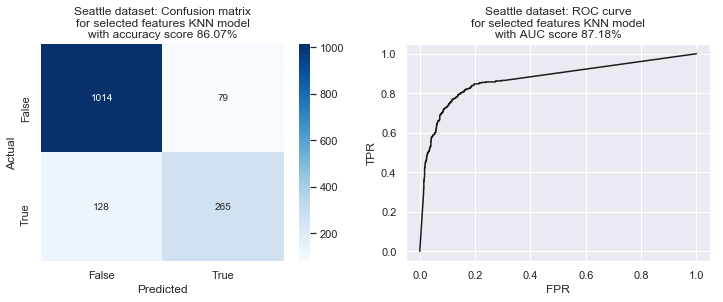

f1-score  precision    recall  support
0             0.907383   0.887916  0.927722   1093.0
1             0.719132   0.770349  0.674300    393.0
micro avg     0.860700   0.860700  0.860700   1486.0
macro avg     0.813257   0.829132  0.801011   1486.0
weighted avg  0.857596   0.856823  0.860700   1486.0

In [31]:
# Obtaining Seattle selected features KNN model report
cls_report, roc_KNN_sea_select = KNNeighborsPipeline(
    X_train_select_sea, X_test_select_sea,
    y_train_sea, y_test_sea,
    'Seattle', 'selected features'
)
cls_report

#### Figure 11 | Confusion matrix, ROC curve, and classification report for Seattle 'selected features' KNN model
The best KNN model for the Seattle 'selected features' dataset acheived an accuracy score of 86.07%, f1-score of 85.76%, and precision of 85.68%, with an overall AUC score of 87.18%. 

##### Seattle Dataset: All Features

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.2min finished


Best hyperparameters:
algorithm        auto
n_neighbors         8
p                   1
weights      distance


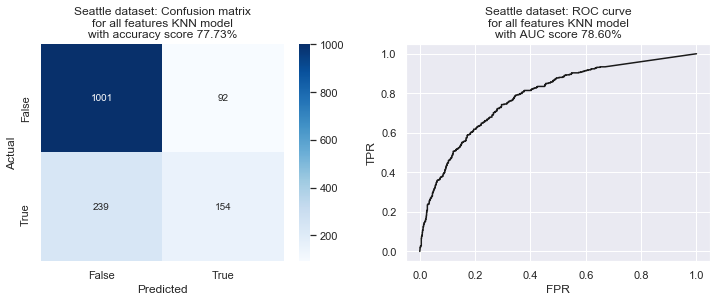

f1-score  precision    recall  support
0             0.858123   0.807258  0.915828   1093.0
1             0.482003   0.626016  0.391858    393.0
micro avg     0.777254   0.777254  0.777254   1486.0
macro avg     0.670063   0.716637  0.653843   1486.0
weighted avg  0.758651   0.759325  0.777254   1486.0

In [32]:
# Obtaining Seattle all features KNN model report
cls_report, roc_KNN_sea = KNNeighborsPipeline(
    X_train_sea, X_test_sea,
    y_train_sea, y_test_sea,
    'Seattle', 'all features'
)
cls_report

#### Figure 12 | Confusion matrix, ROC curve, and classification report for Seattle 'all features' KNN model
The best KNN model for the Seattle 'all features' dataset achieved an accuracy score of 77.73% (v. 86.07% select), 
f1-score of 75.86% (v. 85.76% select), and precision of 75.93% (v. 85.68% select), with an overall AUC score of 
78.60% (v. 87.18% select). Overall, it is clear that the selected features model is better performing.

##### Chicago Dataset: Selected Features

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.2s finished


Best hyperparameters:
algorithm        auto
n_neighbors         9
p                   1
weights      distance


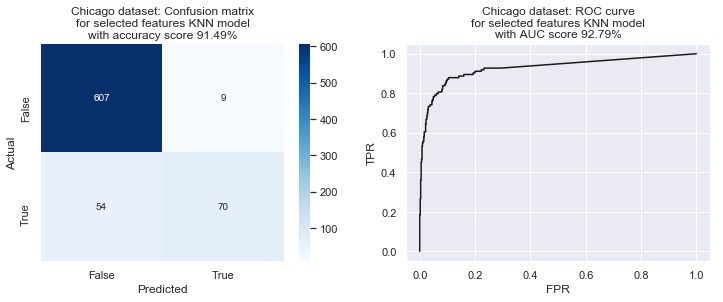

f1-score  precision    recall  support
0             0.950666   0.918306  0.985390    616.0
1             0.689655   0.886076  0.564516    124.0
micro avg     0.914865   0.914865  0.914865    740.0
macro avg     0.820160   0.902191  0.774953    740.0
weighted avg  0.906929   0.912905  0.914865    740.0

In [33]:
# Obtaining Chicago selected features KNN model report
cls_report, roc_KNN_chi_select = KNNeighborsPipeline(
    X_train_select_chi, X_test_select_chi,
    y_train_chi, y_test_chi,
    'Chicago', 'selected features'
)
cls_report

#### Figure 13 | Confusion matrix, ROC curve, and classification report for Chicago 'selected features' KNN model
The best KNN model for the Chicago 'selected features' dataset achieved an accuracy score of 91.49%, 
f1-score of 90.69%, and precision of 91.29%, with an overall AUC score of 92.79%. 

##### Chicago Dataset: All Features

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   10.6s finished


Best hyperparameters:
algorithm        auto
n_neighbors         4
p                   1
weights      distance


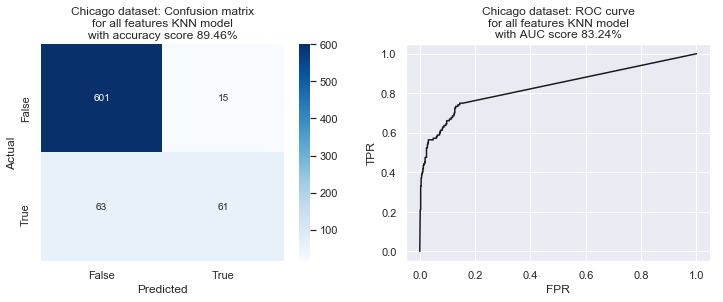

f1-score  precision    recall  support
0             0.939063   0.905120  0.975649    616.0
1             0.610000   0.802632  0.491935    124.0
micro avg     0.894595   0.894595  0.894595    740.0
macro avg     0.774531   0.853876  0.733792    740.0
weighted avg  0.883922   0.887947  0.894595    740.0

In [34]:
# Obtaining Chicago all features KNN model report
cls_report, roc_KNN_chi = KNNeighborsPipeline(
    X_train_chi, X_test_chi,
    y_train_chi, y_test_chi,
    'Chicago', 'all features'
)
cls_report

#### Figure 14 | Confusion matrix, ROC curve, and classification report for Chicago 'all features' KNN model
The best KNN model for the Chicago 'all features' dataset achieved an accuracy score of 89.46% (v. 91.49% select), f1-score of 88.39% (v. 90.69% select), and precision of 88.79% (v. 91.29% select), with an overall AUC score of 83.24% (v. 92.79% select). As with the Seattle dataset, the Chicago selected features model is better performing than the all features model.

### Decision Tree Classifier Results

##### Seattle Dataset: Selected Features

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2264 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   50.1s finished


Best hyperparameters:
criterion          entropy
max_depth                6
min_samples_leaf         9
min_samples_split        2
splitter              best


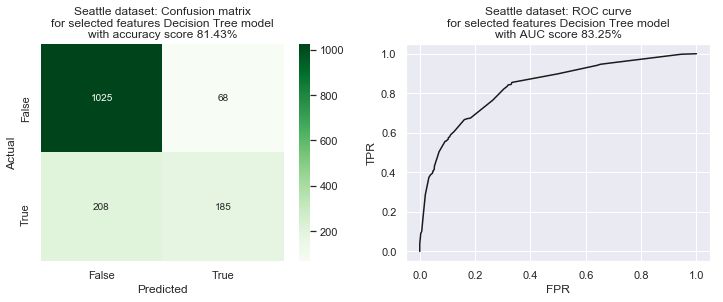

f1-score  precision    recall  support
0             0.881341   0.831306  0.937786   1093.0
1             0.572755   0.731225  0.470738    393.0
micro avg     0.814266   0.814266  0.814266   1486.0
macro avg     0.727048   0.781266  0.704262   1486.0
weighted avg  0.799730   0.804838  0.814266   1486.0

In [35]:
# Obtaining Seattle selected features DT model report
cls_report, roc_DT_sea_select, dt_model_select_sea = DecisionTreePipeline(
    X_train_select_sea, X_test_select_sea,
    y_train_sea, y_test_sea,
    'Seattle', 'selected features'
)
cls_report

#### Figure 15 | Confusion matrix, ROC curve, and classification report for Seattle 'selected features' DT model
The best decision tree model for the Seattle 'selected features' dataset achieved an accuracy score of 81.43%, f1-score of 79.97%, and precision of 80.48%, with an overall AUC score of 83.25%.

Seattle dataset: selected features decision tree with best hyperparameters


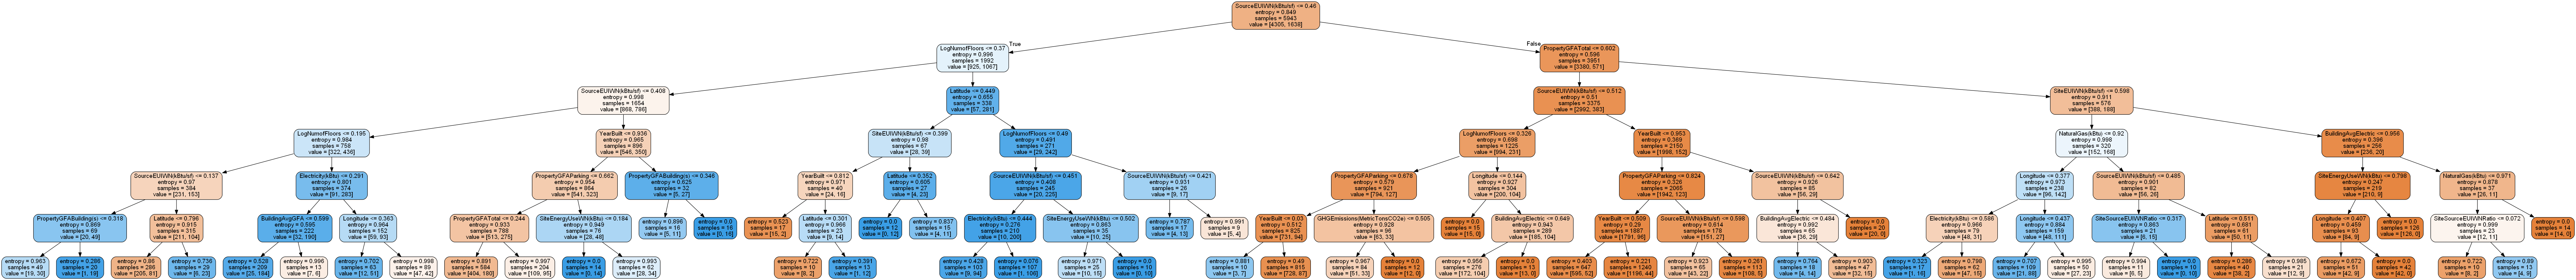

In [36]:
# Displaying decision tree for Seattle selected features model
DisplayDecisionTree(dt_model_select_sea, chosen_cols_sea,
                    'dt_select_sea', 'Seattle', 'selected features', width=5000)

#### Figure 16 | Decision tree for Seattle 'selected features' model
For the 'selected features' Seattle model, SourceEUIWN was chosen as the first node for separating ENERGYSTARClass,
followed by LogNumofFloors and PropertyGFATotal for the 2nd and 3rd. SourceEUIWN, Latitude, SourceEUIWN, and SiteEUIWN
were chosen for the 4th, 5th, 6th, and 7th nodes respectively. As expected, SourceEUIWN and SiteEUIWN were crucial features.

##### Seattle Dataset: All Features

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2768 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  1.2min finished


Best hyperparameters:
criterion          gini
max_depth             6
min_samples_leaf      8
min_samples_split     2
splitter           best


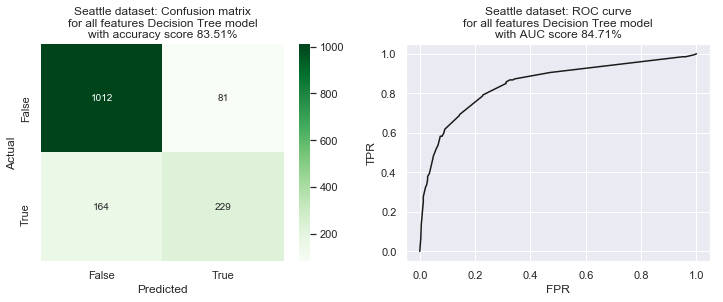

f1-score  precision    recall  support
0             0.892023   0.860544  0.925892   1093.0
1             0.651494   0.738710  0.582697    393.0
micro avg     0.835128   0.835128  0.835128   1486.0
macro avg     0.771758   0.799627  0.754295   1486.0
weighted avg  0.828411   0.828323  0.835128   1486.0

In [37]:
# Obtaining Seattle all features DT model report
cls_report, roc_DT_sea, dt_model_sea = DecisionTreePipeline(
    X_train_sea, X_test_sea,
    y_train_sea, y_test_sea,
    'Seattle', 'all features'
)
cls_report

#### Figure 17 | Confusion matrix, ROC curve, and classification report for Seattle 'all features' DT model
The best decision tree model for the Seattle 'all features' dataset achieved an accuracy score of 83.51% (v. 81.43% select), 
f1-score of 82.84% (v. 79.97% select), and precision of 82.83% (v. 80.48% select), with an overall AUC score of 84.71% (v. 83.25% select). Interestingly, the 'all features' model is better performing than the 'selected features' model, despite
the latter being selected using a decision tree-based classifier (ExtraTreesClassifier). 

Seattle dataset: all features decision tree with best hyperparameters


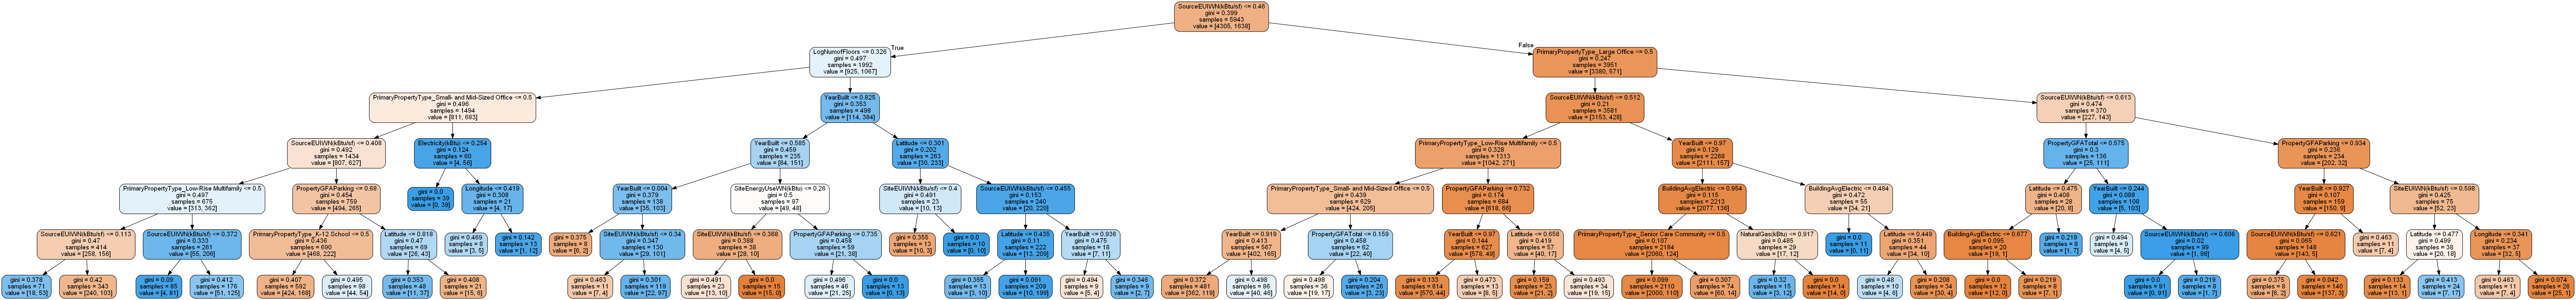

In [38]:
# Displaying decision tree for Seattle all features model
features_sea = list(df_seattle.columns)
features_sea.remove('ENERGYSTARScore')
features_sea.remove('ENERGYSTARClass')
DisplayDecisionTree(dt_model_sea, features_sea, 'dt_sea', 'Seattle', 'all features', width=5000)

#### Figure 18 | Decision tree for Seattle 'all features' model
For the 'all features' Seattle model, SourceEUIWN was chosen as the first node for separating ENERGYSTARClass, followed by LogNumofFloors and PrimaryPropertyType_Large Office for the 2nd and 3rd. PrimaryPropertyType_Small-and Mid-Sized Office, YearBuilt, SourceEUIWN, and SourceEUIWN were chosen for the 4th, 5th, 6th, and 7th nodes respectively. It is interesting to note that, while PrimaryPropertyType features were largely missing from the selected features, they were clearly utilized in the 'all features' model.

##### Chicago Dataset: Selected Features

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 3676 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   23.5s finished


Best hyperparameters:
criterion          entropy
max_depth                5
min_samples_leaf         1
min_samples_split        5
splitter            random


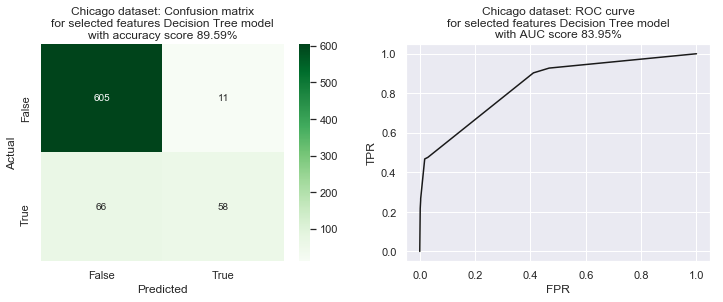

f1-score  precision    recall  support
0             0.940171   0.901639  0.982143    616.0
1             0.601036   0.840580  0.467742    124.0
micro avg     0.895946   0.895946  0.895946    740.0
macro avg     0.770604   0.871110  0.724942    740.0
weighted avg  0.883343   0.891408  0.895946    740.0

In [39]:
# Obtaining Chicago selected features DT model report
cls_report, roc_DT_chi_select, dt_model_select_chi = DecisionTreePipeline(
    X_train_select_chi, X_test_select_chi,
    y_train_chi, y_test_chi,
    'Chicago', 'selected features'
)
cls_report

#### Figure 19 | Confusion matrix, ROC curve, and classification report for Chicago 'selected features' DT model
The best decision tree model for the Chicago 'selected features' dataset achieved an accuracy score of 89.59%, 
f1-score of 88.33% and precision of 89.14%, with an overall AUC score of 83.95%.

Chicago dataset: selected features decision tree with best hyperparameters


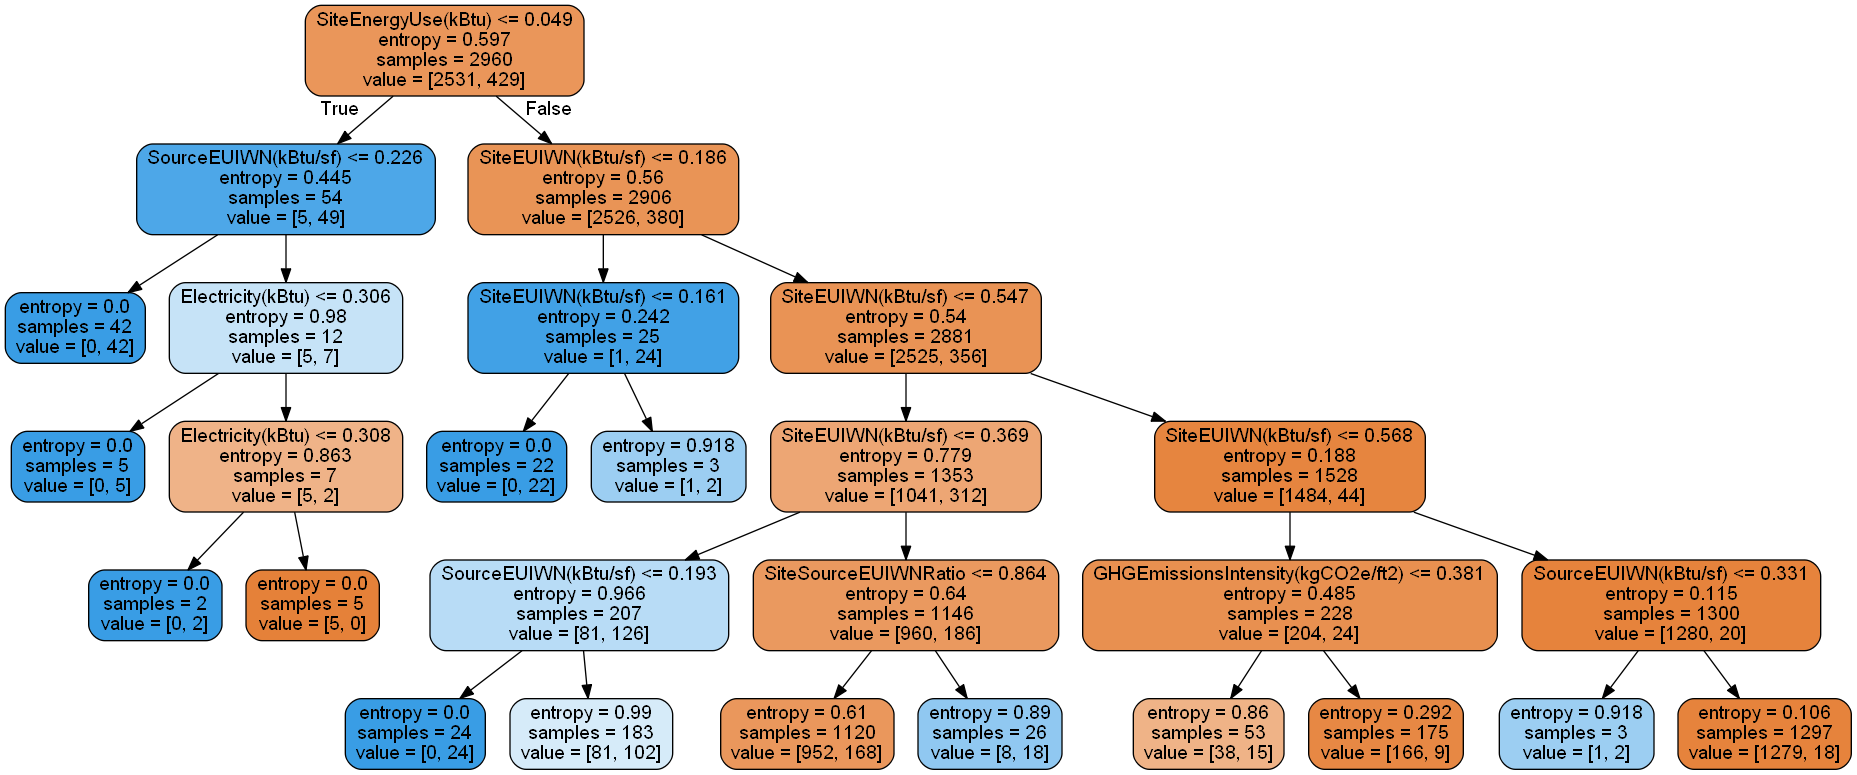

In [40]:
# Displaying decision tree for Chicago selected features model
DisplayDecisionTree(dt_model_select_chi, chosen_cols_chi,
                    'dt_select_chi', 'Chicago', 'selected features', width=2000)

#### Figure 20 | Decision tree for Chicago 'selected features' model
For the 'selected features' Chicago model, SiteEnergyUse was chosen as the first node for separating ENERGYSTARClass, followed by SourceEUIWN and SiteEUIWN for the 2nd and 3rd. Electricity, SiteEUIWN, SiteEUIWN, and Electricity were chosen for the 4th, 5th, 6th, and 7th nodes respectively. As with the Seattle dataset, SourceEUIWN and SiteEUIWN features were central to the selected model.

##### Chicago Dataset: All Features

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 630 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 4260 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   27.3s finished


Best hyperparameters:
criterion          entropy
max_depth                6
min_samples_leaf         6
min_samples_split        2
splitter            random


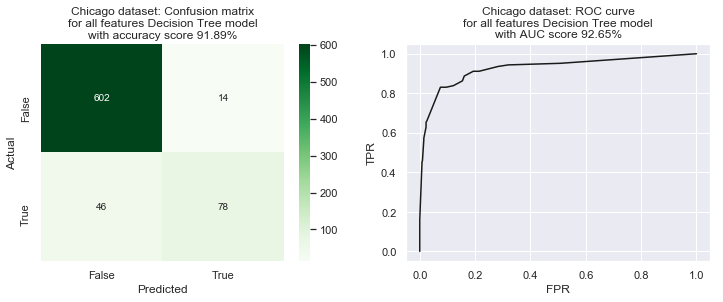

f1-score  precision    recall  support
0             0.952532   0.929012  0.977273    616.0
1             0.722222   0.847826  0.629032    124.0
micro avg     0.918919   0.918919  0.918919    740.0
macro avg     0.837377   0.888419  0.803152    740.0
weighted avg  0.913939   0.915408  0.918919    740.0

In [41]:
# Obtaining Chicago all features DT model report
cls_report, roc_DT_chi, dt_model_chi = DecisionTreePipeline(
    X_train_chi, X_test_chi,
    y_train_chi, y_test_chi,
    'Chicago', 'all features'
)
cls_report

#### Figure 21 | Confusion matrix, ROC curve, and classification report for Chicago 'all features' DT model
The best decision tree model for the Chicago 'all features' dataset achieved an accuracy score of 91.89% (v. 89.59% select), f1-score of 91.39% (v. 88.33% select), and precision of 91.54% (v. 89.14% select), with an overall AUC score of 92.65% (v.83.95% select). As with the Seattle dataset, the all features model is better performing than the selected features model, despite the latter being selected using a decision tree-based classifier.

Chicago dataset: all features decision tree with best hyperparameters


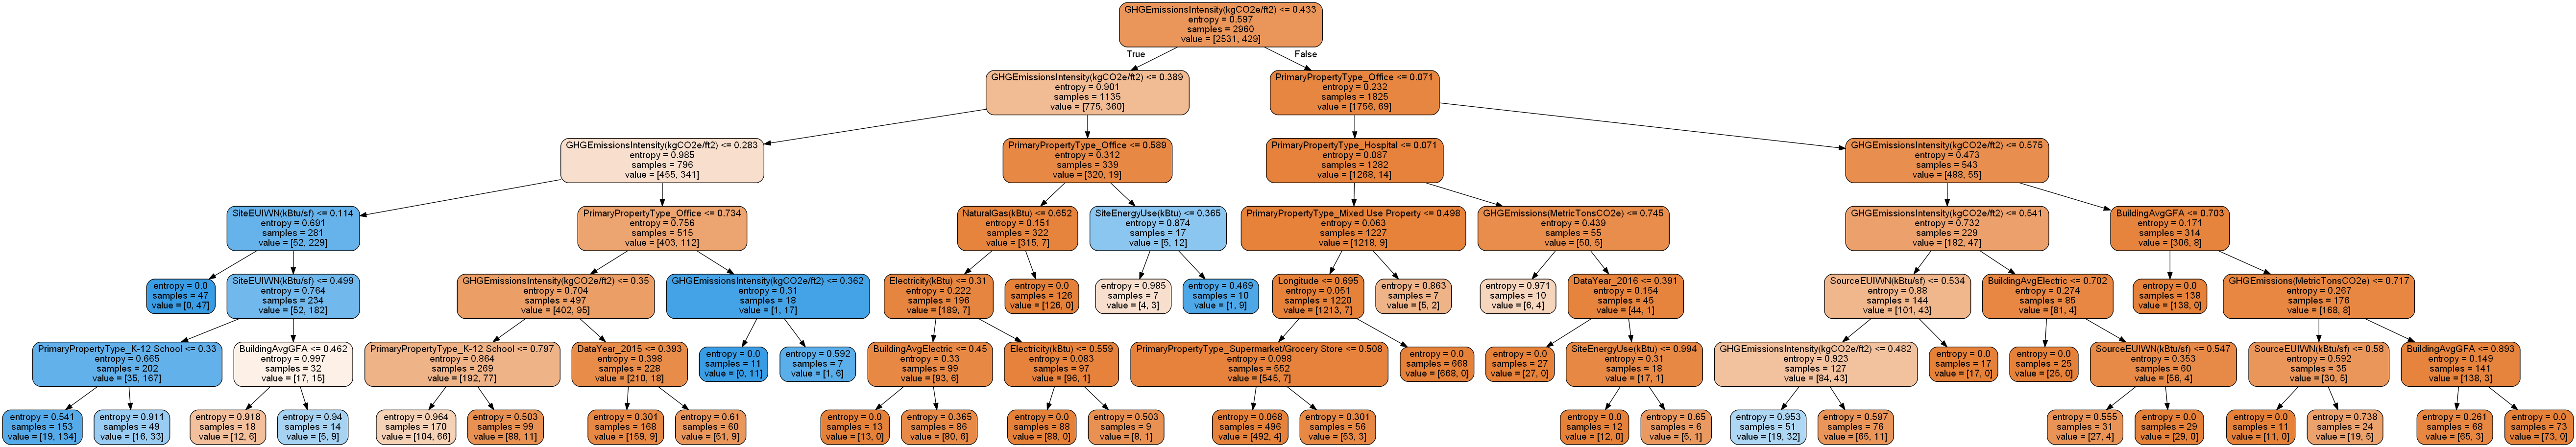

In [42]:
# Displaying decision tree for Chicago all features model
features_chi = list(df_chicago.columns)
features_chi.remove('ENERGYSTARScore')
features_chi.remove('ENERGYSTARClass')
DisplayDecisionTree(dt_model_chi, features_chi, 'dt_chi', 'Chicago', 'all features', width=3000)

#### Figure 22 | Decision tree for Chicago 'all features' model
For the 'all features' Chicago model, GHGEmissionsIntensity was chosen as the first node for separating ENERGYSTARClass, followed by GHGEmissionsIntensity and PrimaryPropertyType_Office for the 2nd and 3rd. GHGEmissionsIntensity, PrimaryPropertyType_Office, PrimaryPropertyType_Hospital, and GHGEmissionsIntensity were chosen for the 4th, 5th, 6th, and 7th nodes respectively. Surprisingly, SiteEUIWN isn't incorporated until the 9th node, whereas GHGEmissionsIntensity, largely missing from any of the other models, is clearly being utilized.

### Support Vector Classifier Results

##### Seattle Dataset: Selected Features

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.4min finished


Best hyperparameters:
C        40
gamma     4
kernel  rbf


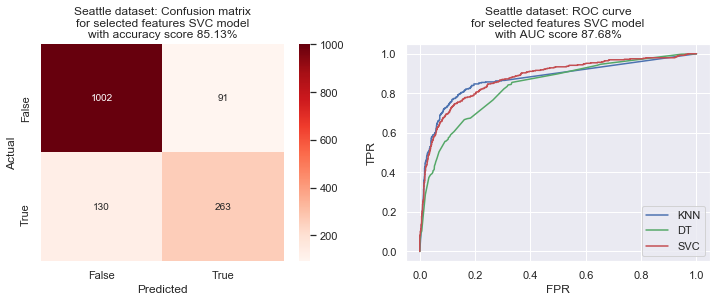

f1-score  precision    recall  support
0             0.900674   0.885159  0.916743   1093.0
1             0.704150   0.742938  0.669211    393.0
micro avg     0.851279   0.851279  0.851279   1486.0
macro avg     0.802412   0.814048  0.792977   1486.0
weighted avg  0.848700   0.847546  0.851279   1486.0

In [43]:
# Obtaining Seattle selected features SVC model report
SvcPipeline(X_train_select_sea, X_test_select_sea,
            y_train_sea, y_test_sea, 'Seattle', 'selected features',
            roc0=roc_KNN_sea_select, roc1=roc_DT_sea_select)

#### Figure 23 | Confusion matrix, ROC curve, and classification report for Seattle 'selected features' SVC model
The best SVC model for the Seattle 'selected features' dataset achieved an accuracy score of 85.13% (v. 86.07% KNN select), 
f1-score of 84.87% (v. 85.76% KNN select), and precision of 84.75% (v. 85.68% KNN select), with an overall AUC score of 87.67% (v. 87.18% KNN select).

Overall, the SVC model is better performing than the decision tree model on all metrics, yet worse than the KNN model on every metric except AUC score, where it was marginally better. Therefore, the KNN classifier is the most performant with the Seattle selected features dataset.

##### Seattle Dataset: All Features

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


Best hyperparameters:
C         50
gamma   auto
kernel   rbf


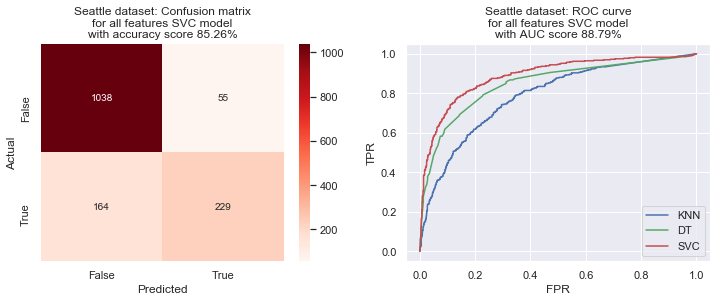

f1-score  precision    recall  support
0             0.904575   0.863561  0.949680   1093.0
1             0.676514   0.806338  0.582697    393.0
micro avg     0.852624   0.852624  0.852624   1486.0
macro avg     0.790545   0.834949  0.766188   1486.0
weighted avg  0.844260   0.848427  0.852624   1486.0

In [44]:
# Obtaining Seattle all features SVC model report
SvcPipeline(X_train_sea, X_test_sea,
            y_train_sea, y_test_sea, 'Seattle', 'all features',
            roc0=roc_KNN_sea, roc1=roc_DT_sea)

#### Figure 24 | Confusion matrix, ROC curve, and classification report for Seattle 'all features' SVC model
The best SVC model for the Seattle 'all features' dataset achieved an accuracy score of 85.26% (v. 85.13% SVC select, 86.07% KNN select), f1-score of 84.43% (v. 84.87% SVC select, 85.76% KNN select), and precision of 84.84% (v. 84.75% SVC select, 85.68% KNN select), with an overall AUC score of 88.79% (v. 87.67% SVC select, 87.18% KNN select).

Overall, the SVC 'all features' model is better peforming than the SVC 'selected features' model on all metrics except f1-score, where it is marginally better; additionally, it is better than either DT or KNN 'all feature' models on all metrics. However, it worse than the KNN select model on every metric except AUC score, where it is moderately better.

##### Chicago Dataset: Selected Features

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   12.0s finished


Best hyperparameters:
C        30
gamma     4
kernel  rbf


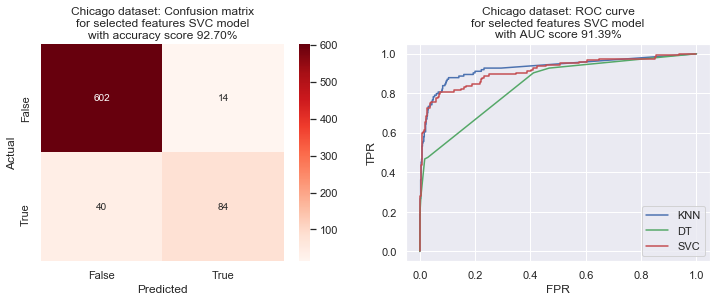

f1-score  precision    recall  support
0             0.957075   0.937695  0.977273    616.0
1             0.756757   0.857143  0.677419    124.0
micro avg     0.927027   0.927027  0.927027    740.0
macro avg     0.856916   0.897419  0.827346    740.0
weighted avg  0.923508   0.924197  0.927027    740.0

In [45]:
# Obtaining Chicago selected features SVC model report
SvcPipeline(X_train_select_chi, X_test_select_chi,
            y_train_chi, y_test_chi, 'Chicago', 'selected features',
            roc0=roc_KNN_chi_select, roc1=roc_DT_chi_select)

#### Figure 25 | Confusion matrix, ROC curve, and classification report for Chicago 'selected features' SVC model
The best SVC model for the Chicago 'selected features' dataset achieved an accuracy score of 92.70% (v. 91.89% DT all), 
f1-score of 92.35% (v. 91.39% DT all), and precision of 92.42% (v. 91.54% DT all), with an overall AUC score of 91.39% (v. 92.79% KNN select, 92.65% DT all).

Overall, the SVC 'selected features' model is better performing than the decision tree select model on all metrics and better than the KNN select model on all metrics except AUC score. The next closest Chicago model would be DT all features, which also has a noticeably higher AUC score than the SVC select model.

##### Chicago Dataset: All Features

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   16.8s finished


Best hyperparameters:
C         50
gamma   auto
kernel   rbf


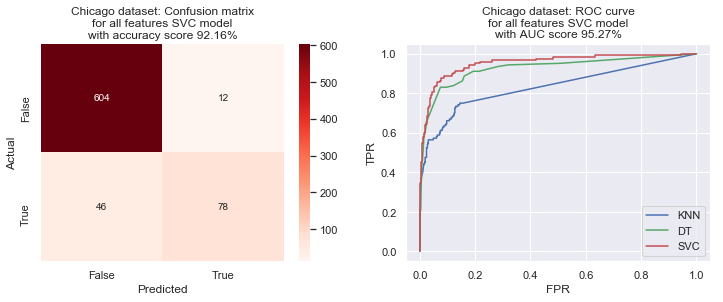

f1-score  precision    recall  support
0             0.954186   0.929231  0.980519    616.0
1             0.728972   0.866667  0.629032    124.0
micro avg     0.921622   0.921622  0.921622    740.0
macro avg     0.841579   0.897949  0.804776    740.0
weighted avg  0.916448   0.918747  0.921622    740.0

In [46]:
# Obtaining Chicago all features SVC model report
SvcPipeline(X_train_chi, X_test_chi,
            y_train_chi, y_test_chi, 'Chicago', 'all features',
            roc0=roc_KNN_chi, roc1=roc_DT_chi)

#### Figure 26 | Confusion matrix, ROC curve, and classification report for Chicago 'all features' SVC model
The best SVC model for the Chicago 'all features' dataset achieved an accuracy score of 92.16% (v. 92.70% SVC select, 91.89% DT all), f1-score of 91.64% (v. 92.35% SVC select, 91.39% DT all), and precision of 91.87% (v. 92.42% SVC select, 91.54% DT all), with an overall AUC score of 95.27% (v. 91.39% SVC select, 92.65% DT all).

Overall, the SVC 'all features' model performs slightly worse than the SVC 'selected features' model on all metrics except AUC score, where it is significantly better. In comparison to other classifiers and feature combinations, the SVC 'all features' model is better across all metrics.

<hr>
### Results Summary
For the Seattle dataset, a KNN classifier using selected features would likely be the most performant when distguishing additional entries by ENERGYSTARClass, with the current model achieving 86.07% accuracy on the test data. However, if the objective is primarily increasing the true positive rate rather than limiting the false positive rate, then the SV classifier using all features would likely be more performant.

For the Chicago dataset, a Support Vector classifier using all features would likely be the most performant when distguishing additional entries by ENERGYSTARClass, with the current model achieving 92.16% accuracy on the test data. However, if the objective is primarily reducing the false postive rate rather than maximizing the true positive rate, then the SV classifier using selected features would likely be more performant.
<hr>

## Time on Tasks

| Task | Time | 
| :--- | ---: | 
| Data Retrieval |  ~20 Hours |
| Data Preparation & Exploration |  ~40 Hours |
| Feature Selection & Engineering |  ~15 Hours |
| Data Modeling & Evaluation |  ~20 Hours |
| Deriving Insight |  ~15 Hours |